In [1]:
# coding:utf-8
import math
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
%matplotlib inline
print "done"

done


# 1.数据处理

## 加载分词

In [2]:
# 停用词加载
import codecs
stopwords = []
with codecs.open('./stopwords_full.txt', 'r', 'utf-8') as f:
    stopwords = [i.rstrip() for i in f.readlines()]
    
# 新加停用词，使用tf-idf筛选
# with codecs.open('./stopwords_new.txt', 'r', 'utf-8') as f:
#     stopwords += [i.rstrip() for i in f.readlines()]
stopwords.append(' ')
stopwords.append(u'\x1d')
print('停用词个数：{}'.format(len(stopwords)))

stopwords_dict = dict(zip(stopwords, range(len(stopwords))))

# 结巴字典加载
jieba.load_userdict('./medical_jieba.dic')
print "done"

Building prefix dict from the default dictionary ...
Loading model from cache /mnt/d/work/appointment/appointment-code/jieba.cache


停用词个数：1896


Loading model cost 0.607 seconds.
Prefix dict has been built succesfully.


done


## 处理数据

In [3]:
# 读取数据，分词，储存
des_list = list()

with codecs.open('../data/traindata_all_processed.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
for line in tqdm.tqdm(contents):
    line_s = line.split('\t')
    if len(line_s) < 2:
        continue
    des = line_s[0]
    depart = line_s[1].strip()
    
    des_jieba = jieba.cut_for_search(des)
    des_final = u' '.join([j for j in des_jieba if (not stopwords_dict.has_key(j)) 
                              and (re.search(pattern=u'[\u4e00-\u9fa5]+', string=j))])
    # 分词后，疾病描述不能为空
    if not des_final=='':
        des_list.append((depart, des_final))
        
# 存储
with codecs.open('../data/search_appointments_split_raw.txt', 'wb', 'utf-8') as f:
    for (label, des) in des_list:
        w = u'{}\t{}\n'.format(label, des)
        f.write(w)
print ("分词数据保存成功")

100%|██████████| 246616/246616 [02:12<00:00, 1854.32it/s]


分词数据保存成功


In [4]:
# # 统计样本长度
# len_dict = dict()
# for label, des in des_list:
#     length = len(des.split(" "))
#     if len_dict.has_key(length):
#         len_dict[length] += 1
#     else:
#         len_dict[length] = 1
# for key in len_dict.keys():
#     print key, len_dict[key]

## 统计TF-IDF

In [5]:
# from collections import defaultdict

# alldata = defaultdict(list)

# with open("../data/search_appointments_split_raw.txt", 'rb') as f:
#     for aline in f.readlines():
#         lines = aline.split("\t")
#         alldata[lines[0]] += lines[1].split(' ')
        
# for key in alldata.keys():
#     alldata[key] = " ".join(alldata[key])
# vectorizer = CountVectorizer()
# transformer = TfidfTransformer()
# tfidf = transformer.fit_transform(vectorizer.fit_transform(alldata.values()))

# word = vectorizer.get_feature_names()
# print "done"

In [6]:
# threshhold = 400
# topDict = defaultdict(list)

# for i, key in enumerate(alldata.keys()):
#     # 筛选tf-idf高的词
#     sortIndex = (-tfidf[i].toarray()).argsort()[0]
#     for j, index in enumerate(sortIndex):
#         topDict[key].append(word[index])
#         if j == threshhold-1:
#             break
# # 打印看看
# # for key in topDict.keys():
# #     print "*"*40
# #     print key
# #     for word in topDict[key]:
# #         print word
# wordset = set([j for i in topDict.values() for j in i])
# count = dict()
# for aword in wordset:
#     count[aword] = 0
# for key, wordlist in topDict.items():
#     for aword in wordlist:
#         count[aword] += 1
# res = sorted(count.iteritems(), key=lambda item:item[1], reverse = True)
# for (a, b) in res:
#     print a
#     if b<30:
#         break

In [7]:
# cut_des_list = list()
# threshhold = 30
# with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
#     for aline in f.readlines():
#         line = aline.split('\t')
#         depart = line[0]
#         des = line[1].split(' ')
#         length = len(des)
#         if length >= threshhold:
#             rem = length % 30
            

## 处理数据（替换相似词）

In [8]:
sub_dict = dict()
new_data = list()
with codecs.open('../word2vec/sub_dict.txt', 'rb', 'utf-8') as f:
    for line in f.readlines():
        line_s = line.split('\t')
        sub_word = line_s[0]
        sub_set = set(line_s[1].split(" "))
        sub_dict[sub_word] = sub_set

with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in tqdm.tqdm(contents):
            line_s = line.split('\t')
            department = line_s[0]
            description = line_s[1].split(" ")
            new_description = list()
            for aword in description:
                aword = aword.strip()
                found = False
                for sub_word in sub_dict.keys():
                    if aword in sub_dict[sub_word]:
                        new_description.append(sub_word)
                        found = True
                        break
                if not found:
                    new_description.append(aword)
            new_data.append((department, new_description))

            # 储存        
with codecs.open('../data/search_appointments_split.txt', 'wb', 'utf-8') as f:
    for (label, des) in new_data:
        des = [i.strip() for i in des]
        w = u'{}\t{}\n'.format(label, " ".join(des))
        f.write(w)
print "储存成功"

100%|██████████| 246206/246206 [26:50<00:00, 152.89it/s]


储存成功


# 2.筛选科室

## 二级科室

In [9]:
# 创建目录
if not os.path.exists('../data/depart'):
    os.makedirs('../data/depart')
if not os.path.exists('../data/depart_data'):
    os.makedirs('../data/depart_data')
if not os.path.exists('../data/model'):
    os.makedirs('../data/model')

In [10]:
# 二级科室划分训练集与数据集
def erji_department_s(deName):
    # 数据处理 分层 train/test
    SPLIT_RATE = 0.8
    label_index_list = list()
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(deName), 'rb', 'utf-8') as f:
        contents = f.readlines()
        descrip_data = contents
        for line in contents:
            line_s = line.split('\t')
            label_index_list.append(line_s[0].encode('utf-8'))

    label_dict = dict()
    for index in range(len(label_index_list)):
        label = label_index_list[index]

        if label_dict.has_key(label):
            label_dict[label].append(index)
        else:
            label_dict.setdefault(label, [index])
    train_list = list()
    test_list = list()
    train_num_dict = dict()
    # 设置是否过采样
    over_sampling = False

    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)

        llist = label_dict[label_aim]

        train_num_dict[label_aim] = int(SPLIT_RATE*len(llist))

    max_samp_num = max(train_num_dict.values())   

    print('二级科目数：{}'.format(len(label_dict.keys())))
    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)
        llist = label_dict[label_aim]
        np.random.shuffle(llist)

        train_slen = train_num_dict[label_aim]
        for sindex in llist[:train_slen]:
            train_list.append(descrip_data[sindex])

        if over_sampling:
            over_count_need = (max_samp_num/train_slen-1)*train_slen
            over_count = 0
            over_indexs = np.random.randint(0, train_slen, over_count_need)
            for over_index in over_indexs:
                sindex = llist[over_index]
                train_list.append(descrip_data[sindex])

        for sindex in llist[train_slen:]:
            test_list.append(descrip_data[sindex])

    np.random.shuffle(train_list)
    np.random.shuffle(test_list)

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line)

    with codecs.open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line)
            
    # 训练集字典生成，以及测试集合词筛选
    # 到时候做 低频词筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.read()
        
    # 对训练集统计词
    train_countv = CountVectorizer()
    result_train_countv = train_countv.fit_transform([train_contents])

    train_vocabulary = train_countv.vocabulary_
    print('训练集词语数：{}'.format(len(train_countv.vocabulary_)))

    LESS_FRE_WORD = 0
    train_dictionary = list()

    #低频词筛选
    for word, value in train_vocabulary.iteritems():
        if result_train_countv[0, value] > LESS_FRE_WORD:
            train_dictionary.append(word.encode('utf-8'))

    print('低频词筛选后词语数：{}'.format(len(train_dictionary)))
    with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_dictionary:
            f.write(line.decode('utf-8')+'\n')
    train_dictionary = dict(zip(train_dictionary, range(len(train_dictionary))))


    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.read()
        
    # 对测试集统计词
    test_countv = CountVectorizer()
    result_test_countv = test_countv.fit_transform([test_contents])

    test_vocabulary = test_countv.vocabulary_
    print('测试集词语数：{}'.format(len(test_countv.vocabulary_))) 

    # 通过字典，分别对train数据集和test数据集筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.readlines()
        print('筛选前训练集大小：{}'.format(len(train_contents)))
    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.readlines()
        print('筛选前测试集大小：{}'.format(len(test_contents)))

    train_list = list()
    test_list = list()
    
    # 训练集
    for line in train_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            train_list.append('{}\t{}'.format(label, ' '.join(words)))

    # 测试集
    for line in test_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            test_list.append('{}\t{}'.format(label, ' '.join(words)))

    print('筛选后训练集大小：{}'.format(len(train_list)))
    print('筛选后测试集大小：{}'.format(len(test_list)))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line.decode('utf-8')+'\n')

    with codecs.open('../data/depart_data/search_appointments_split_test_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line.decode('utf-8')+'\n')

In [11]:
# 二级科室模型训练
def fast_text_model(deName):           
    # set params
    with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'rb') as f:
        content = f.readlines()
        count = len(content)
    
    lr = 0.3
    epoch = int(100*math.sqrt(200000/count))
    bucket = int(math.sqrt((float(count)/200000))*2000000)
    print deName, count, lr, epoch, bucket
    keshi = deName
    input_file = '../data/depart_data/search_appointments_split_train_{}.txt'.format(keshi)
    output = '../data/model/app_model_{}'.format(keshi)
    dim=50
    loss= 'hs'
    lr_update_rate = 98
    ws = 5
    min_count=2
    neg = 2
    word_ngrams= 5
    thread=5
    silent=1
    label_prefix='__label__'

    # Train the classifier
    classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                         lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                         min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                         thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)


    result = classifier_app.test(input_file)
    print('Train:')
    print('P@1:', result.precision)
    print('R@1:', result.recall)
    print('Number of examples:', result.nexamples)

    test_result = classifier_app.test('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi), 1)
    print('Test:')
    print('P@1:', test_result.precision)
    print('R@1:', test_result.recall)
    print('Number of examples:', test_result.nexamples)

    labels_right = []
    texts = []
    with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi)) as fr:
        lines = fr.readlines()
    for line in lines:
        labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
        texts.append(line.split("\t")[1].decode("utf-8"))
    #     print labels
    #     print texts
    #     break
    labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
    # print labels_predict

    text_labels = list(set(labels_right))
    text_predict_labels = list(set(labels_predict))
    # print text_predict_labels
    # print text_labels

    A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
    B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
    C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
    for i in range(0,len(labels_right)):
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1

    # print A 
    # print B
    # print C
    select_department_dict = pkl.load(open('../data/depart/department_{}.pkl'.format(keshi), 'rb'))
    select_de_tup = select_department_dict.items()
    new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

    rlist = list()
    #计算准确率，召回率，F值
    for key in B:
        if int(B[key]) == 0:
            r = 0
        else:
            r = round(A[key] / float(B[key]), 3)
        if int(C[key]) == 0:
            p = 0
        else:
            p = round(A[key] / float(C[key]), 3)
        if (p+r) == 0:
            f1 = 0
        else:
            f1 = round(p * r * 2 / (p + r), 3)
        rlist.append([key,new_dict.get(key),r,p,f1,int(B[key])])
#         print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)
    rdataf = pd.DataFrame(rlist, columns=['Key', 'Department', 'Recall', 'Precision', 'F1', 'Support'])
    print(rdataf)

In [12]:
# 数据处理，根据一级科目筛选，并保存label对应关系
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    
    des_list = list()
    select_depart_dict = dict()

    with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in contents:
            line_s = line.split('\t')
            department = line_s[0].encode('utf-8')
            
            if department in select_department:
                if not select_depart_dict.has_key(department):
                    select_depart_dict[department] = len(select_depart_dict.keys())
                des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))

    #保存科室与label对应关系
    if len(select_depart_dict.keys()) == 0:
        continue
        
    store_tup = sorted(select_depart_dict.items(), key=lambda item:item[1])
    with codecs.open('../data/depart/department_{}.txt'.format(fdepart_name), 'wb','utf-8') as f:
        for depart, index in store_tup:
            f.write(('{}\t{}\n'.format(depart, index)).decode('utf-8'))

    pkl.dump(select_depart_dict, open('../data/depart/department_{}.pkl'.format(fdepart_name), 'wb'))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(fdepart_name), 'w', 'utf-8') as f:
        for (label, des) in des_list:
            f.write(u'{}\t{}'.format(label, des))  
    print fdepart, "done"
print "done"

内科 done
儿科 done
外科 done
妇产科 done
肿瘤科 done
五官科 done
皮肤性病科 done
骨科 done
血液科 done
感染科 done
心理健康 done
康复科 done
中医科 done
男科 done
疼痛科 done
风湿免疫科 done
急诊科 done
done


In [13]:
# 划分训练集测试集
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        fdepart_name = line.split('：')[2].strip()

        print('*'*40)
        print(line.split('：')[0].strip())
        erji_department_s(fdepart_name)
print "done"

****************************************
内科
二级科目数：7
训练集词语数：39697
低频词筛选后词语数：39697
测试集词语数：18948
筛选前训练集大小：44351
筛选前测试集大小：11094
筛选后训练集大小：44319
筛选后测试集大小：11082
****************************************
儿科
二级科目数：2
训练集词语数：14950
低频词筛选后词语数：14950
测试集词语数：6819
筛选前训练集大小：10005
筛选前测试集大小：2503
筛选后训练集大小：10000
筛选后测试集大小：2499
****************************************
外科
二级科目数：8
训练集词语数：35103
低频词筛选后词语数：35103
测试集词语数：16454
筛选前训练集大小：40768
筛选前测试集大小：10196
筛选后训练集大小：40731
筛选后测试集大小：10186
****************************************
妇产科
二级科目数：2
训练集词语数：16186
低频词筛选后词语数：16186
测试集词语数：7639
筛选前训练集大小：14383
筛选前测试集大小：3597
筛选后训练集大小：14377
筛选后测试集大小：3595
****************************************
肿瘤科
二级科目数：1
训练集词语数：11473
低频词筛选后词语数：11473
测试集词语数：5414
筛选前训练集大小：5662
筛选前测试集大小：1416
筛选后训练集大小：5660
筛选后测试集大小：1416
****************************************
五官科
二级科目数：3
训练集词语数：23694
低频词筛选后词语数：23694
测试集词语数：11279
筛选前训练集大小：21572
筛选前测试集大小：5396
筛选后训练集大小：21564
筛选后测试集大小：5392
****************************************
皮肤性病科
二级科目数：2
训练集词语数：15553
低频词筛选后词语数：15553
测试

In [14]:
# 二级模型训练与测试
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    
    # 二级科目只有一个，无需分类
    if len(sdepart_list)==1:
        print fdepart, "pass"
        continue
        
    fdepart_name = line_s[2].strip()
    print('*'*40)
    print(fdepart)
    fast_text_model(fdepart_name)
    print('\n')
print "done"

****************************************
内科
neike 44319 0.3 200 941477
Train:
('P@1:', 0.9990523251878427)
('R@1:', 0.9990523251878427)
('Number of examples:', 44319)
Test:
('P@1:', 0.8191662154845696)
('R@1:', 0.8191662154845696)
('Number of examples:', 11082)
  Key Department  Recall  Precision     F1  Support
0   1       消化内科   0.867      0.829  0.848     1799
1   0       内分泌科   0.835      0.844  0.839     1755
2   3       普通内科   0.484      0.648  0.554     1207
3   2        肾内科   0.863      0.914  0.888     1192
4   5       呼吸内科   0.891      0.872  0.881     1799
5   4       神经内科   0.859      0.772  0.813     1798
6   6      心血管内科   0.844      0.810  0.827     1532


****************************************
儿科
erke 10000 0.3 447 447213
Train:
('P@1:', 0.9997)
('R@1:', 0.9997)
('Number of examples:', 10000)
Test:
('P@1:', 0.9203681472589036)
('R@1:', 0.9203681472589036)
('Number of examples:', 2499)
  Key Department  Recall  Precision     F1  Support
0   1         儿科   0.966      0.

# 一级科室

In [15]:
# 生成一级科目label对应文件
# import json
first_secondDepart = dict()
second_firstDepart = dict()

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        fdepart = line_s[0]
        sdepart_list = line_s[1].split('，')
        sdepart_list = [i.strip() for i in sdepart_list]
        first_secondDepart.setdefault(fdepart, sdepart_list)
        for sdepart in sdepart_list:
            second_firstDepart.setdefault(sdepart, fdepart)

#print json.dumps(first_secondDepart, encoding="UTF-8", ensure_ascii=False)
#print json.dumps(second_firstDepart, encoding="UTF-8", ensure_ascii=False)
            
select_department_zip = zip(first_secondDepart.keys(), range(len(first_secondDepart.keys())))

with codecs.open('../data/department.txt', 'wb','utf-8') as f:
    for (d, i) in select_department_zip:
        f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

select_department_dict = dict(select_department_zip)
pkl.dump(select_department_dict, open('../data/department.pkl', 'wb'))

print "done"

done


In [16]:
# # 统计一下数据中病人科室分布情况

# WORDS_COUNT = 700
# department_counts = appointment_data.department_std.value_counts()
# print '二级科室数：' , len(department_counts)
# print department_counts
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len(department_counts[department_counts>WORDS_COUNT]))

# select_department = department_counts[department_counts>WORDS_COUNT].keys()
# black_list = ['特诊部','未定义','其他']
# white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
#              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('./data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('./data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [17]:
# print len(second_firstDepart)
# print len(select_department_dict)

In [18]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('./data/department_freq_select.pkl', 'rb'))
# first_department_dict = pkl.load(open('./data/department.pkl', 'rb'))

# des_list = list()

# with codecs.open('./data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department) and second_firstDepart.has_key(department):
#             first_depart = second_firstDepart[department]
#             des_list.append(('__label__{}'.format(first_department_dict[first_depart]), u''.join(line_s[1:])))

# # 存储
# with codecs.open('./data/search_appointments_freq_select_split.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label, des))
# print "done"

In [19]:
## 测试jieba功能
# print(appointment_data.disease_desc.loc[91717])


# aaa = jieba.cut(appointment_data.disease_desc.loc[91717])
# for i in aaa:
#     if not stopwords_dict.has_key(i):
#         print(i)
#         print([i])
# # print(' '.join(aaa))
# print(' '.join([j.strip() for j in aaa if j not in stopwords_dict]))

# print(des_list[91717][1])
# # appointment_data.disease_desc.loc[91717]

# FastText数据集

In [20]:
import fasttext
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
# 合并二级科目训练集测试集，生成一级科目训练集测试集
first_label = pkl.load(open('../data/department.pkl', 'rb'))

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    des_dict_train = dict()
    des_dict_test = dict()
    des_dict_test_final = dict()
    for line in contents:
        depart_name_ch = line.split('：')[0].strip()
        depart_name_py = line.split('：')[2].strip()
        second_label = pkl.load(open('../data/depart/department_{}.pkl'.format(depart_name_py), 'rb'))
        second_label = dict(zip(second_label.values(), second_label.keys()))
        label = '__label__' + str(first_label[depart_name_ch])
        
        
        # 训练集合并
        des_list_train = list()
        with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_train.append(line.split('\t')[1])
        
        np.random.shuffle(des_list_train)
        des_dict_train[label] = des_list_train
        
        
        #测试集合并
        des_list_test = list()
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_test.append(line.split('\t')[1])
                
        np.random.shuffle(des_list_test)
        des_dict_test[label] = des_list_test
        
        #测试集合并（最终用）
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                this_label = line.split('\t')[0].replace('__label__', '')
                second_depart = second_label[int(this_label)]
                if not des_dict_test_final.has_key(second_depart):
                    des_dict_test_final[second_depart] = [line.split('\t')[1]]
                else:
                    des_dict_test_final[second_depart].append(line.split('\t')[1])

train_list = list()
test_list = list()

for key in des_dict_train.keys():
        for des in des_dict_train[key]:
            train_list.append('{}\t{}'.format(key, des))

for key in des_dict_test.keys():
        for des in des_dict_test[key]:
            test_list.append('{}\t{}'.format(key, des))
            
np.random.shuffle(train_list)
np.random.shuffle(test_list)
            
# 存储
with codecs.open('../data/search_appointments_split_train.txt', 'wb', 'utf-8') as f:
    for line in train_list:
        f.write(line.decode('utf-8'))
        

with codecs.open('../data/search_appointments_split_test.txt', 'wb', 'utf-8') as f:
    for line in test_list:
        f.write(line.decode('utf-8'))
        
with codecs.open('../data/search_appointments_split_test_final.txt', 'wb', 'utf-8') as f:
    for key in des_dict_test_final.keys():
        for des in des_dict_test_final[key]:
            f.write("{}\t{}".format(key, des).decode('utf-8'))
        
print "done"

done


In [22]:
print "训练集大小："
for key in des_dict_train.keys():
    print key, len(des_dict_train[key])
    
print "测试集大小："
for key in des_dict_test.keys():
    print key, len(des_dict_test[key])
print "done"

训练集大小：
__label__8 40731
__label__9 4789
__label__0 21564
__label__1 10382
__label__2 10000
__label__3 4031
__label__4 7186
__label__5 44319
__label__6 4622
__label__7 14377
__label__12 7191
__label__13 965
__label__10 5660
__label__11 4625
__label__16 5050
__label__14 4560
__label__15 4852
测试集大小：
__label__8 10186
__label__9 1198
__label__0 5392
__label__1 2596
__label__2 2499
__label__3 1008
__label__4 1798
__label__5 11082
__label__6 1155
__label__7 3595
__label__12 1797
__label__13 242
__label__10 1416
__label__11 1156
__label__16 1261
__label__14 1138
__label__15 1212
done


# FastText

In [23]:
# set params
keshi = 'yiji'
input_file = '../data/search_appointments_split_train.txt'
output = '../data/model/app_model'
dim=50
lr=0.3
loss= 'hs'
lr_update_rate = 98
epoch=100
ws = 5
min_count=2
neg = 2
word_ngrams= 5
bucket=2000000
thread=10
silent=1
label_prefix='__label__'

# Train the classifier
classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                     lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                     min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                     thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)

result = classifier_app.test(input_file)
print('Train:')
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
print('Test:')
print('P@1:', test_result.precision)
print('R@1:', test_result.recall)
print('Number of examples:', test_result.nexamples)

labels_right = []
texts = []
with open('../data/search_appointments_split_test.txt') as fr:
    lines = fr.readlines()
for line in lines:
    labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
    texts.append(line.split("\t")[1].decode("utf-8"))
#     print labels
#     print texts
#     break
labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# print labels_predict

text_labels = list(set(labels_right))
text_predict_labels = list(set(labels_predict))
# print text_predict_labels
# print text_labels

A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
for i in range(0,len(labels_right)):
    B[labels_right[i]] += 1
    C[labels_predict[i]] += 1
    if labels_right[i] == labels_predict[i]:
        A[labels_right[i]] += 1

# print A 
# print B
# print C
select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup = select_department_dict.items()
new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))
print "done"

Train:
('P@1:', 0.9980144070927226)
('R@1:', 0.9980144070927226)
('Number of examples:', 194904)
Test:
('P@1:', 0.7627382980033244)
('R@1:', 0.7627382980033244)
('Number of examples:', 48731)
done


In [24]:
## 计算准确率，召回率，F值
depart_name = []
precision = []
recall = []
f1_measure = []
for key in B:
    r = float(A[key]) / float(B[key])
    recall.append(r)
    p = float(A[key]) / float(C[key])
    precision.append(p)
    f1 = p * r * 2 / (p + r)
    f1_measure.append(f1)
    depart_name.append(new_dict.get(key))
    print "%2s: %-16s \t p:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),p,r,f1)
for index in range(len(depart_name)):
    depart_name[index] = depart_name[index].decode('utf-8')
print "done"

11: 血液科        	 p:0.810056	r:0.752595	f:0.780269	
10: 肿瘤科        	 p:0.774905	r:0.719633	f:0.746247	
13: 康复科        	 p:0.771689	r:0.698347	f:0.733189	
12: 骨科           	 p:0.652995	r:0.673344	f:0.663014	
15: 风湿免疫科  	 p:0.782790	r:0.773102	f:0.777916	
14: 感染科        	 p:0.716389	r:0.641476	f:0.676866	
16: 男科           	 p:0.641395	r:0.670896	f:0.655814	
 1: 皮肤性病科  	 p:0.757493	r:0.749615	f:0.753533	
 0: 五官科        	 p:0.848546	r:0.855156	f:0.851838	
 3: 急诊科        	 p:0.812567	r:0.756944	f:0.783770	
 2: 儿科           	 p:0.678398	r:0.725090	f:0.700967	
 5: 内科           	 p:0.761283	r:0.779282	f:0.770177	
 4: 中医科        	 p:0.616976	r:0.481090	f:0.540625	
 7: 妇产科        	 p:0.841192	r:0.863421	f:0.852162	
 6: 疼痛科        	 p:0.503443	r:0.569697	f:0.534525	
 9: 心理健康     	 p:0.753894	r:0.808013	f:0.780016	
 8: 外科           	 p:0.794948	r:0.787846	f:0.791381	
done


In [25]:
#! /usr/bin/env python 
# -*- coding: utf-8 -*- 
## 绘图函数
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  

# font = FontProperties(fname=r"/mnt/c/Windows/Fonts/simsun.ttc", size=10) 

def draw_bar(x, y, heading):
    plt.figure(figsize=(9,3),dpi=100)
    plt.bar(range(len(x)), y, tick_label=x)
    plt.xticks(rotation=60, fontsize=12)
#     ax=plt.gca()
#     ax.set_xticklabels(x, fontproperties=font)
#     plt.title(heading, fontproperties=font)
#     plt.xlabel(u'科室')
    plt.ylabel(heading, fontsize=15)
#     plt.ylabel(heading, fontproperties=font)
    plt.grid(True)
    plt.show()

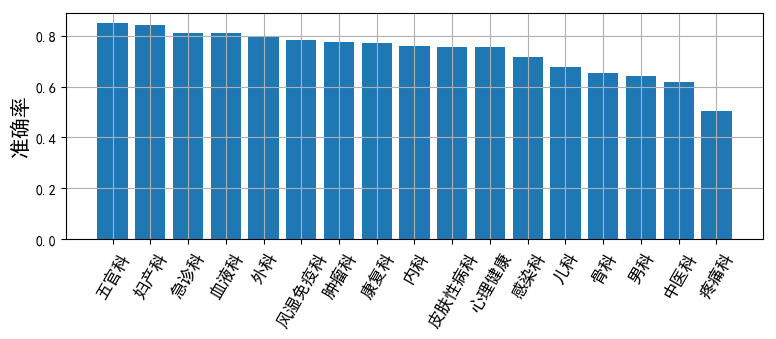

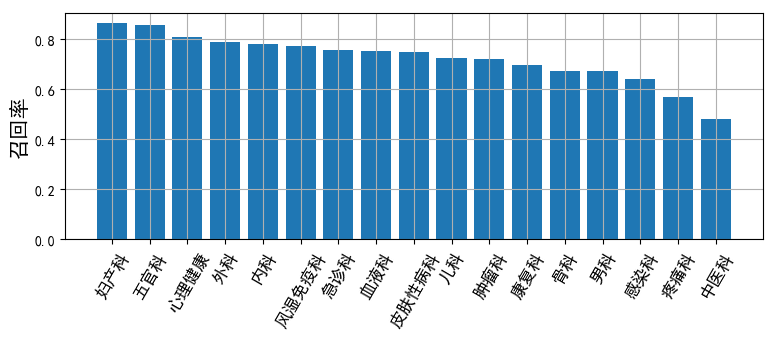

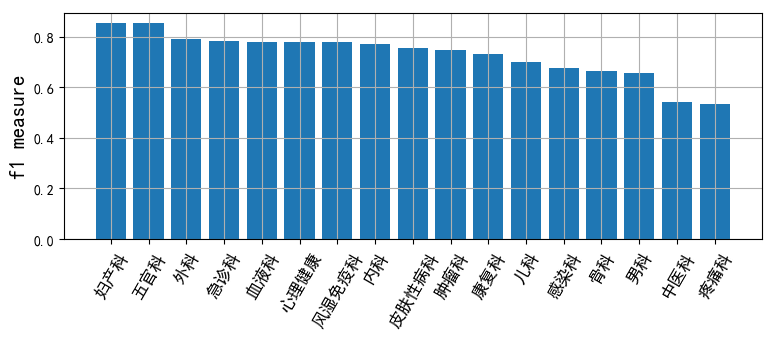

In [26]:
## 绘图   
precision_dict = dict(zip(depart_name, precision))
precision_list = sorted(precision_dict.items(), key=lambda item:item[1], reverse=True)
recall_dict = dict(zip(depart_name, recall))
recall_list = sorted(recall_dict.items(), key=lambda item:item[1], reverse=True)
f1_dict = dict(zip(depart_name, f1_measure))
f1_list = sorted(f1_dict.items(), key=lambda item:item[1], reverse=True)
draw_bar([i[0] for i in precision_list], [i[1] for i in precision_list], u'准确率')
draw_bar([i[0] for i in recall_list], [i[1] for i in recall_list], u'召回率')
draw_bar([i[0] for i in f1_list], [i[1] for i in f1_list], 'f1 measure')

# 4.预测

In [8]:
# coding:utf-8
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
%matplotlib inline
print "done"

done


## 4.1 数据预处理

In [2]:
# # 统计科室数据量 过滤样本不足的科室

# WORDS_COUNT = 1000
# depart_count = dict()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if not depart_count.has_key(department):
#             depart_count[department] = 1
#         else:
#             depart_count[department] += 1

# depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
    
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len([count for (depart, count) in depart_count if count > WORDS_COUNT]))

# select_department = [depart for (depart, count) in depart_count if count > WORDS_COUNT]
# # black_list = ['特诊部','未定义','其他']
# # white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
# #              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# # select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('../data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('../data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [3]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('../data/department_freq_select.pkl', 'rb'))

# des_list = list()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department):
#             des_list.append((department, u''.join(line_s[1:])))

# # 存储
# with codecs.open('../data/final_test.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label.decode('utf-8'), des))
# print "done"

## 4.2 测试

In [4]:
#加载一级科目训练集词汇
train_dictionary_first = list()
with codecs.open('../data/word_dictionary.txt', 'rb', 'utf-8') as f:
    cont = f.readlines()
    for line in cont:
        train_dictionary_first.append(line.strip())
train_dictionary_first = dict(zip(train_dictionary_first, range(len(train_dictionary_first))))

#加载一级科目对应关系
select_department_dict_first = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup_first = select_department_dict_first.items()
new_dict_first = dict(zip([str(x[1]) for x in select_de_tup_first], [x[0] for x in select_de_tup_first]))


#加载二级科目训练集词汇
train_dictionary_second = dict()
new_dict_second = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        deName = line_s[2].strip()
        train_dictionary_second[deName] = list()
        new_dict_second[deName] = dict()
        
        #加载二级科目对应关系
        with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'rb', 'utf-8') as f:
            cont = f.readlines()
            for line in cont:
                train_dictionary_second[deName].append(line.strip())
        train_dictionary_second[deName] = dict(zip(train_dictionary_second[deName], range(len(train_dictionary_second[deName]))))
        
        select_department_dict_second = pkl.load(open('../data/depart/department_{}.pkl'.format(deName), 'rb'))
        select_de_tup_second = select_department_dict_second.items()
        new_dict_second[deName] = dict(zip([str(x[1]) for x in select_de_tup_second], [x[0] for x in select_de_tup_second]))

print 'done' 

done


In [5]:
# 二层模型
def first_part_decide(model, sentence, prothresh = 0.05):    
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_first.has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_first.get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

def second_part_decide(model, sentence, deName, prothresh = 0.05):
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_second[deName].has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_second[deName].get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

In [6]:
# 模型加载
first_departPath = '../data/model/app_model.bin'

first_departModel = fasttext.load_model(first_departPath)

second_departModel_dict = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
modelList = dict()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    if len(sdepart_list) == 1:
        continue
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    modelList[fdepart] = fdepart_name
    secondmodel = fasttext.load_model('../data/model/app_model_{}.bin'.format(fdepart_name))
    second_departModel_dict[fdepart] = secondmodel

print "done"

done


In [7]:
# 加载数据
des_list = list()
label_list = list()
# # 过滤后的科室
# with codecs.open('../data/final_test.txt', 'rb', 'utf-8') as f:
# 未过滤的科室
with codecs.open('../data/search_appointments_split_test_final.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        label = line_s[0].encode('utf-8')
        des = line_s[1]
        label_list.append(label)
        des_list.append(des)
print 'done'

done


In [38]:
labels_right = list()
texts = list()
labels_predict = list()

count = defaultdict(int)

for des_index in tqdm.tqdm(range(len(des_list))):
    des = des_list[des_index]
    first_result = first_part_decide(first_departModel, des)
    
    if first_result == None:
        continue
    if len(first_result) != 5:
        continue
    
    print '-'*40
    print des

    optim_depart = ''
    optim_pro = 0.0
    
    for (fdepart, fpro, fkey) in first_result:
        print '*'*40
        print fdepart, fpro
        if second_departModel_dict.has_key(fdepart):
            second_result = second_part_decide(second_departModel_dict[fdepart], des, modelList[fdepart])
            if second_result == None:
                continue
            for (sdepart, spro, skey) in second_result:
                print sdepart, spro
                if spro > optim_pro:
                    optim_depart = sdepart
                    optim_pro = spro
        else:
            print fdepart, fpro
            if fpro > optim_pro:
                optim_depart = fdepart
                optim_pro = fpro
    print '*'*40
    print "final", optim_depart, optim_pro
    print label_list[des_index]
            
#     print(optim_fdepart)
    if optim_depart!= '':
        labels_predict.append(optim_depart)
        texts.append(des)
        labels_right.append(label_list[des_index])

# for index in range(len(test_data_data)):
#     print('描述：{}'.format(test_data_data[index]))
#     print('科室：{}'.format(res_list[index]))
#     print('\n')

  3%|▎         | 1541/48731 [00:00<00:05, 7869.76it/s]

----------------------------------------
妈妈 眼睛 舒服 回事 这么回事 眼皮 疙瘩 妈妈 紧接 眼睛 舒服 几天 体检 大夫 功能 障碍 功能障碍 症状 功能 障碍 功能障碍 治疗 谢谢 谢谢您 热敷 一周 没什么 效果 这是 回事 这么回事 多久 效果 谢谢 谢谢

****************************************
内科 0.304966
普通内科 0.436658
神经内科 0.331808
内分泌科 0.122716
心血管内科 0.0927746
****************************************
五官科 0.30216
眼科 0.988281
****************************************
外科 0.156555
泌尿外科 0.52808
普外科 0.256365
神经外科 0.192614
****************************************
疼痛科 0.0690201
疼痛科 0.0690201
****************************************
中医科 0.0540043
中医科 0.0540043
****************************************
final 眼科 0.988281
眼科
----------------------------------------
眼睛 白色 一根 白色 絮状物 黄褐色 淡黄色 不适 半年

****************************************
五官科 0.502636
眼科 1.0
****************************************
血液科 0.191495
血液科 0.191495
****************************************
风湿免疫科 0.178708
风湿免疫科 0.178708
****************************************
心理健康 0.0600577
心理科 0.671875
精神科 0.326172
*********************

  5%|▍         | 2318/48731 [00:00<00:09, 5125.26it/s]


眼科
----------------------------------------
眼肌 调节 麻痹 平面 看成 凸面 歪斜 症状 复视

****************************************
外科 0.358887
神经外科 0.938341
****************************************
内科 0.288425
神经内科 0.980575
****************************************
骨科 0.116157
骨科 0.116157
****************************************
五官科 0.104054
眼科 0.840454
耳鼻咽喉科 0.153694
****************************************
中医科 0.0878162
中医科 0.0878162
****************************************
final 神经内科 0.980575
眼科
----------------------------------------
分化 结缔 组织 结缔组织 患者 去年 月份 查出 情绪 波动 很大 低烧 药都 整天 无精打采 头昏 吃药 退烧 情绪 波动 时间 请问 时间 长时间

****************************************
心理健康 0.481773
精神科 0.888672
心理科 0.109375
****************************************
风湿免疫科 0.216505
风湿免疫科 0.216505
****************************************
疼痛科 0.0926784
疼痛科 0.0926784
****************************************
感染科 0.0901736
感染科 0.0901736
****************************************
血液科 0.0828738
血液科 0.0828738
************************************

  6%|▋         | 3054/48731 [00:00<00:12, 3589.86it/s]

疼痛科 0.44951
疼痛科 0.44951
****************************************
风湿免疫科 0.136681
风湿免疫科 0.136681
****************************************
外科 0.119171
神经外科 0.432199
脊柱外科 0.328533
血管外科 0.159491
****************************************
内科 0.119171
肾内科 0.453465
神经内科 0.297959
消化内科 0.0875019
普通内科 0.0731727
****************************************
感染科 0.077324
感染科 0.077324
****************************************
final 肾内科 0.453465
风湿免疫科
----------------------------------------
教授 你好 十多 多年 十多年 感觉 身体 右侧 舒服 按摩 电疗 贴膏药 中药 治疗 效果 不好 两年 感觉 身体 特别 晚上 睡觉 睡觉时 好像 翻身 活动 缓解 检查 舒服 去年 河南 强直 强直性 强直性 脊柱 强直性 轻微 三个 疗程 中药 颗粒 感觉 减轻 发现 右侧 臀部 右上 有点痛 抽筋 感觉 活动 蹲下 感觉 大便 感觉 按摩 电疗 贴膏药 中药 治疗

****************************************
风湿免疫科 0.334915
风湿免疫科 0.334915
****************************************
骨科 0.267702
骨科 0.267702
****************************************
中医科 0.148091
中医科 0.148091
****************************************
外科 0.114784
脊柱外科 0.833396
神经外科 0.10072
****************************************
疼痛科 0.10799
疼

  8%|▊         | 3747/48731 [00:00<00:13, 3320.55it/s]

 0.3308
眼科 0.503883
耳鼻咽喉科 0.490265
****************************************
外科 0.0601807
神经外科 0.555017
泌尿外科 0.196138
普外科 0.168322
****************************************
心理健康 0.0596916
心理科 0.560547
精神科 0.4375
****************************************
皮肤性病科 0.0502144
皮肤科 0.990234
****************************************
final 皮肤科 0.990234
心理科
----------------------------------------
妹妹 十九 七岁 二十七岁 原因 上学 几个 打工 两天 前两天 家去 我妈 回来 家里 一家 家人 一家人 家里 不管怎么 妹妹 一家 家人 一家人 操心

****************************************
疼痛科 0.228782
疼痛科 0.228782
****************************************
外科 0.167862
泌尿外科 0.437708
神经外科 0.294189
普外科 0.0836644
血管外科 0.0766037
****************************************
皮肤性病科 0.165231
皮肤科 0.677734
性病科 0.320313
****************************************
感染科 0.122292
感染科 0.122292
****************************************
风湿免疫科 0.0940046
风湿免疫科 0.0940046
****************************************
final 皮肤科 0.677734
心理科
----------------------------------------
家里 出门 交流 一睡 五六 六天 五六天 特别 打电话 生活

 10%|▉         | 4789/48731 [00:01<00:11, 3983.53it/s]


风湿免疫科 0.104096
风湿免疫科 0.104096
****************************************
康复科 0.058484
康复科 0.058484
****************************************
外科 0.0561981
泌尿外科 0.980549
****************************************
final 泌尿外科 0.980549
急诊科
----------------------------------------
四五 五天 四五天 看过 医治 方法 医治 有过 多久 用药 手术

****************************************
皮肤性病科 0.49624
皮肤科 0.998047
****************************************
肿瘤科 0.152539
肿瘤科 0.152539
****************************************
内科 0.100937
神经内科 0.452109
消化内科 0.256565
呼吸内科 0.138184
普通内科 0.0952377
****************************************
中医科 0.0656603
中医科 0.0656603
****************************************
风湿免疫科 0.0504749
风湿免疫科 0.0504749
****************************************
final 皮肤科 0.998047
急诊科
----------------------------------------
症状 主要症状 不便 行动不便 一段 时间 段时间 一段时间 治愈 好转 效果 咨询 治愈 发病 时间 化验 检查

****************************************
疼痛科 0.331044
疼痛科 0.331044
****************************************
外科 0.22525
血管外科 0.695537
脊柱外科 0.12

 12%|█▏        | 5650/48731 [00:01<00:10, 4024.97it/s]


****************************************
感染科 0.0634699
感染科 0.0634699
****************************************
final 性病科 0.998047
性病科
----------------------------------------
桑拿 按摩 小姐 定期 身体 体检 检查 身体检查

****************************************
外科 0.532913
肝胆外科 0.620322
血管外科 0.369141
****************************************
疼痛科 0.139599
疼痛科 0.139599
****************************************
血液科 0.0853663
血液科 0.0853663
****************************************
感染科 0.0847254
感染科 0.0847254
****************************************
风湿免疫科 0.0811902
风湿免疫科 0.0811902
****************************************
final 肝胆外科 0.620322
性病科
----------------------------------------
大夫 昔洛韦 两盒 口服 说明书 两盒 六片 只能 三盒 三天 剂量

****************************************
儿科 0.242855
儿科 0.771484
新生儿科 0.226563
****************************************
妇产科 0.226172
产科 0.513672
妇科 0.484375
****************************************
内科 0.126869
神经内科 0.579406
消化内科 0.212242
呼吸内科 0.107849
心血管内科 0.0901758
*****************************

 14%|█▎        | 6644/48731 [00:01<00:09, 4212.65it/s]

0.173668
神经内科 0.0543599
****************************************
final 精神科 1.0
精神科
----------------------------------------
不到 背部 时间 胳膊 近些 近些年 好像 发展 治疗 郁闷 几家 医院 办法 说出 病症 时间 关系 放下

****************************************
皮肤性病科 0.43753
皮肤科 0.953125
****************************************
外科 0.134449
泌尿外科 0.41746
普外科 0.393651
肝胆外科 0.105807
****************************************
疼痛科 0.0967165
疼痛科 0.0967165
****************************************
感染科 0.0804238
感染科 0.0804238
****************************************
男科 0.0721482
男科 0.0721482
****************************************
final 皮肤科 0.953125
脊柱外科
----------------------------------------
妻子 无意 发现 核磁 共振 磁共振 核磁共振 确诊

****************************************
肿瘤科 0.4621
肿瘤科 0.4621
****************************************
外科 0.296841
神经外科 0.990234
****************************************
妇产科 0.0946476
妇科 0.544922
产科 0.453125
****************************************
中医科 0.0684191
中医科 0.0684191
****************************************
骨

 16%|█▌        | 7715/48731 [00:01<00:09, 4398.90it/s]


心血管内科 0.0514198
****************************************
中医科 0.232837
中医科 0.232837
****************************************
疼痛科 0.132266
疼痛科 0.132266
****************************************
心理健康 0.123916
精神科 0.888672
心理科 0.109375
****************************************
感染科 0.113509
感染科 0.113509
****************************************
final 精神科 0.888672
脊柱外科
----------------------------------------
十七岁 五年 十五年 患有 骨髓 骨髓炎 手术 复发 上个 上个月 复发 共振 磁共振 左足 第三 型号 异常 信号 组织 软组织 肿胀 增强 异常 强化 左足 未见 骨质 异常 关节 在位 关节 少量 积液 十七岁 五年 十五年 手术 治疗 周前 反复 骨髓 骨髓炎

****************************************
疼痛科 0.367433
疼痛科 0.367433
****************************************
骨科 0.269695
骨科 0.269695
****************************************
外科 0.176125
脊柱外科 0.919279
神经外科 0.0594872
****************************************
风湿免疫科 0.10057
风湿免疫科 0.10057
****************************************
血液科 0.0564005
血液科 0.0564005
****************************************
final 脊柱外科 0.919279
脊柱外科
----------------------------------------


 18%|█▊        | 8677/48731 [00:01<00:09, 4415.94it/s]

 妇科 1.0
妇科
----------------------------------------
戊酸 雌二醇 片会 出血 周二 周五 稍微 出血 昨天 稍微 多点 感觉 厕所 小便 马桶 红色 这药 囊肿 手术 上个 上个月 例假 三天 出血 止血 止血药 紧接 上个 上个月 例假 日子 不多 出血 止血 血块 出血 治疗 囊肿

****************************************
妇产科 0.401515
妇科 0.984375
****************************************
外科 0.253029
泌尿外科 0.700841
普外科 0.205817
****************************************
血液科 0.13686
血液科 0.13686
****************************************
内科 0.12368
消化内科 0.636321
肾内科 0.192637
神经内科 0.0555089
****************************************
疼痛科 0.068427
疼痛科 0.068427
****************************************
final 妇科 0.984375
妇科
----------------------------------------
你好 确诊 慢性 盆腔 盆腔炎 肛门 塞药 请问 肛门 塞药 几个 小时 大便 晚上 塞药 二天 第二天 厕所 感觉 好像 拉稀 这算 情况 影响 药效 塞药 几个 小时 排便 医生 开给 早上 阴道 小时 厕所

****************************************
疼痛科 0.299115
疼痛科 0.299115
****************************************
妇产科 0.220579
妇科 0.705078
产科 0.292969
****************************************
感染科 0.181539
感染科 0.181539
**********************************

 20%|█▉        | 9560/48731 [00:02<00:10, 3846.66it/s]


****************************************
五官科 0.41588
眼科 0.87706
耳鼻咽喉科 0.101494
****************************************
外科 0.262756
肛肠外科 0.7842
普外科 0.109595
神经外科 0.0523892
****************************************
康复科 0.0945335
康复科 0.0945335
****************************************
急诊科 0.0811269
急诊科 0.0811269
****************************************
皮肤性病科 0.0768237
皮肤科 0.935547
性病科 0.0625
****************************************
final 皮肤科 0.935547
普外科
----------------------------------------
症状 主要症状 发病 时间 化验 检查 子宫 子宫癌 手术 几天 发生 刀口 破裂 大便 东西 医生 医生 咳嗽 小肠 破裂 请问

****************************************
外科 0.40332
普外科 0.949405
****************************************
肿瘤科 0.190599
肿瘤科 0.190599
****************************************
内科 0.166359
消化内科 0.992203
****************************************
皮肤性病科 0.109014
皮肤科 0.865234
性病科 0.132813
****************************************
五官科 0.10083
耳鼻咽喉科 0.567249
眼科 0.428848
****************************************
final 消化内科 0.992203
普外科
----------

 22%|██▏       | 10500/48731 [00:02<00:09, 4107.95it/s]

 0.976604
****************************************
皮肤性病科 0.130486
皮肤科 1.0
****************************************
妇产科 0.0694659
产科 0.894531
妇科 0.103516
****************************************
final 皮肤科 1.0
普外科
----------------------------------------
表舅 舅妈 感觉 身体 舒服 说不上 说不上来 舒服 医院 检查 医生 坐骨 听说 病情

****************************************
中医科 0.544777
中医科 0.544777
****************************************
血液科 0.125978
血液科 0.125978
****************************************
内科 0.104034
内分泌科 0.459643
心血管内科 0.26084
消化内科 0.12589
神经内科 0.122487
****************************************
感染科 0.074869
感染科 0.074869
****************************************
骨科 0.0630419
骨科 0.0630419
****************************************
final 中医科 0.544777
普外科
----------------------------------------
上个 上个月 身体 舒服 医院 检查 医生 阴囊 肿大 手术 手术 十天 感觉 不多 身体 没什么 舒服 地方 开学 落下

****************************************
感染科 0.349861
感染科 0.349861
****************************************
疼痛科 0.187013
疼痛科 0.187013
***********************

 24%|██▎       | 11557/48731 [00:02<00:07, 4649.60it/s]

----------------------------------------
癌胚抗原 癌胚抗原 指数 请问 科室

****************************************
血液科 0.300148
血液科 0.300148
****************************************
肿瘤科 0.24039
肿瘤科 0.24039
****************************************
外科 0.187988
普外科 0.690258
肝胆外科 0.210526
泌尿外科 0.095314
****************************************
骨科 0.135503
骨科 0.135503
****************************************
妇产科 0.0768957
妇科 0.998047
****************************************
final 妇科 0.998047
肿瘤科
----------------------------------------
长征 医院 长征 查出 查出来 喷门癌 做手 手术 做手术 片子 不用 化验 常规 化验 做过 资料 不用 化验 自费

****************************************
内科 0.321396
内分泌科 0.467432
普通内科 0.216532
心血管内科 0.129712
肾内科 0.0925402
消化内科 0.0681835
****************************************
血液科 0.179209
血液科 0.179209
****************************************
外科 0.158882
血管外科 0.311472
肝胆外科 0.278531
脊柱外科 0.172304
普外科 0.0883681
神经外科 0.0546443
****************************************
感染科 0.0761371
感染科 0.0761371
*******************************

 25%|██▍       | 12086/48731 [00:02<00:07, 4741.65it/s]

 0.21608
心血管内科 0.531694
内分泌科 0.258119
呼吸内科 0.0810623
消化内科 0.0697694
****************************************
风湿免疫科 0.206504
风湿免疫科 0.206504
****************************************
康复科 0.133666
康复科 0.133666
****************************************
急诊科 0.122152
急诊科 0.122152
****************************************
final 儿科 1.0
肿瘤科
----------------------------------------
走路 米左右 床上 不痛 脚要 抬起 放在 地上

****************************************
风湿免疫科 0.581541
风湿免疫科 0.581541
****************************************
骨科 0.186324
骨科 0.186324
****************************************
内科 0.0857697
神经内科 0.982513
****************************************
疼痛科 0.0716233
疼痛科 0.0716233
****************************************
康复科 0.0642234
康复科 0.0642234
****************************************
final 神经内科 0.982513
骨科
----------------------------------------
背痛 五年 早上 痛醒 不着 睡不着 起床 好些 这是 增强 共振 磁共振

****************************************
疼痛科 0.275649
疼痛科 0.275649
****************************************
骨科 0.227

 27%|██▋       | 13047/48731 [00:03<00:09, 3888.87it/s]

0.996094
骨科
----------------------------------------
骨质 疏松 全身 治疗 触电 钻心 药物

****************************************
骨科 0.561758
骨科 0.561758
****************************************
感染科 0.217651
感染科 0.217651
****************************************
风湿免疫科 0.0750776
风湿免疫科 0.0750776
****************************************
疼痛科 0.0624993
疼痛科 0.0624993
****************************************
内科 0.0517044
神经内科 0.549828
心血管内科 0.2295
内分泌科 0.162722
****************************************
final 骨科 0.561758
骨科
----------------------------------------
儿子 晚上 脚面 侧面 袜子 发现 双脚 对称 部位 一大 一大块 一大块 肿块 不痛 不痒 请问 医生 这是 回事 这么回事 谢谢

****************************************
外科 0.481598
普外科 0.910655
泌尿外科 0.0815513
****************************************
中医科 0.147271
中医科 0.147271
****************************************
皮肤性病科 0.0979461
皮肤科 0.996094
****************************************
内科 0.0917359
普通内科 0.645348
内分泌科 0.278642
****************************************
五官科 0.0671711
口腔科 0.892578
耳鼻咽喉科 0.0776596
*

 28%|██▊       | 13463/48731 [00:03<00:10, 3468.58it/s]

 0.302317
眼科 1.0
****************************************
儿科 0.240398
儿科 1.0
****************************************
风湿免疫科 0.112952
风湿免疫科 0.112952
****************************************
疼痛科 0.0944191
疼痛科 0.0944191
****************************************
心理健康 0.0513944
精神科 1.0
****************************************
final 眼科 1.0
骨科
----------------------------------------
膝盖 发炎 专家 家门 门诊 专家门诊 感谢 非常感谢 帮别人 预约 查看 预约 信息 就诊 内容

****************************************
骨科 0.261009
骨科 0.261009
****************************************
内科 0.246765
普通内科 0.8556
心血管内科 0.0704464
****************************************
外科 0.231171
普外科 0.923394
****************************************
五官科 0.152183
口腔科 0.576172
眼科 0.3815
****************************************
儿科 0.0514267
儿科 0.998047
****************************************
final 儿科 0.998047
骨科
----------------------------------------
听说 中医 偏方 治好 能治好 真的 两年 办法 医生 复发 中医 偏方 办法

****************************************
皮肤性病科 0.312763
皮肤科 0.988281
**

 30%|██▉       | 14451/48731 [00:03<00:08, 4003.89it/s]

0.0551525
****************************************
final 皮肤科 0.996094
内分泌科
----------------------------------------
症状 手淫 现象 每次 高潮 很快 感觉 阴茎 发育 迟缓 治疗

****************************************
男科 0.428183
男科 0.428183
****************************************
中医科 0.183203
中医科 0.183203
****************************************
心理健康 0.162221
心理科 0.970703
****************************************
皮肤性病科 0.122954
性病科 1.0
****************************************
外科 0.0891075
泌尿外科 1.0
****************************************
final 性病科 1.0
内分泌科
----------------------------------------
母亲 姐们 病状 母亲 后天性 因素 小孩 症状 几率 谢谢

****************************************
皮肤性病科 0.454822
皮肤科 0.96875
****************************************
外科 0.227051
泌尿外科 0.51052
肝胆外科 0.237856
神经外科 0.184849
****************************************
五官科 0.111461
眼科 0.51495
耳鼻咽喉科 0.414871
口腔科 0.0664063
****************************************
肿瘤科 0.0711092
肿瘤科 0.0711092
****************************************
儿科 0.0564905
儿科 0.568359

 32%|███▏      | 15540/48731 [00:03<00:07, 4591.46it/s]

肾内科 0.161721
心血管内科 0.0815429
****************************************
final 儿科 0.976563
内分泌科
----------------------------------------
上个 星期 上个星期 姐姐 医院 检查 急死了 求助 医生 解决 谢谢

****************************************
内科 0.267483
肾内科 0.499023
消化内科 0.498049
****************************************
中医科 0.170775
中医科 0.170775
****************************************
五官科 0.150843
耳鼻咽喉科 0.998047
****************************************
急诊科 0.148936
急诊科 0.148936
****************************************
风湿免疫科 0.132157
风湿免疫科 0.132157
****************************************
final 耳鼻咽喉科 0.998047
内分泌科
----------------------------------------
口服 达英 一年 停药 一个月 上次 月经 否认 怀孕 停药 时间 段时间 特别 这是 回事 这么回事 皮肤 皮肤科 皮肤 过敏 皮肤过敏 心慌 停药 脸红 厉害 医生 建议 排除 甲状腺 疾病

****************************************
内科 0.412445
内分泌科 0.9883
****************************************
中医科 0.191661
中医科 0.191661
****************************************
心理健康 0.182375
精神科 0.658203
心理科 0.339844
****************************************
妇产科 0.128109
妇

 34%|███▍      | 16456/48731 [00:03<00:08, 3745.73it/s]

神经外科 0.580492
普外科 0.242391
脊柱外科 0.0825157
****************************************
中医科 0.12188
中医科 0.12188
****************************************
皮肤性病科 0.11257
皮肤科 0.990234
****************************************
final 皮肤科 0.990234
感染科
----------------------------------------
我刚 管好 原先 做过 麻子

****************************************
中医科 0.366104
中医科 0.366104
****************************************
急诊科 0.220852
急诊科 0.220852
****************************************
骨科 0.152121
骨科 0.152121
****************************************
妇产科 0.0837863
产科 1.0
****************************************
风湿免疫科 0.052485
风湿免疫科 0.052485
****************************************
final 产科 1.0
感染科
----------------------------------------
您好 母亲 住院 体温 请问 出院 口服 服药 口服药

****************************************
康复科 0.584154
康复科 0.584154
****************************************
急诊科 0.133401
急诊科 0.133401
****************************************
风湿免疫科 0.0528646
风湿免疫科 0.0528646
*************************************

 36%|███▋      | 17697/48731 [00:04<00:07, 4415.20it/s]

0.265232
肝胆外科 0.0995546
神经外科 0.0686139
脊柱外科 0.0525413
****************************************
急诊科 0.0556952
急诊科 0.0556952
****************************************
final 皮肤科 0.886719
感染科
----------------------------------------
班上 一名 同学 患上 一种 怪病 全身 症状 好多 多个 地方 舒服 好几 几家 好几家 医院 查出 原因 医生 怀疑 热病

****************************************
感染科 0.345143
感染科 0.345143
****************************************
皮肤性病科 0.255018
皮肤科 0.941406
性病科 0.0566406
****************************************
内科 0.203949
内分泌科 0.528644
心血管内科 0.213491
消化内科 0.124695
神经内科 0.0884122
****************************************
肿瘤科 0.0666153
肿瘤科 0.0666153
****************************************
中医科 0.063618
中医科 0.063618
****************************************
final 皮肤科 0.941406
感染科
----------------------------------------
不知 渐渐 流脓 点儿 恶臭 医院 检查 外阴 阿米巴 阿米巴 阿米巴病 局部 脓包 破溃 溃疡 医院 治疗 好转

****************************************
感染科 0.252118
感染科 0.252118
****************************************
五官科 0.167379
耳鼻咽喉科 0.854568
眼科 0.09474

 39%|███▊      | 18808/48731 [00:04<00:06, 4839.38it/s]


----------------------------------------
乳房 检查 双乳 多发 结节 长期 服用 避孕药 避孕药 服用 那种 停止 服用 全套 安全套 避孕药 方法 双乳 多发 结节 手术 服药 方式 改善 痊愈 谢谢

****************************************
中医科 0.317213
中医科 0.317213
****************************************
内科 0.20961
内分泌科 0.502731
呼吸内科 0.275894
消化内科 0.0982399
神经内科 0.0791474
****************************************
疼痛科 0.148028
疼痛科 0.148028
****************************************
骨科 0.131806
骨科 0.131806
****************************************
妇产科 0.0822728
妇科 0.986328
****************************************
final 妇科 0.986328
乳腺外科
----------------------------------------
请问 钢圈 影响 女性 身体 体健 健康 体健

****************************************
皮肤性病科 0.356827
皮肤科 0.941406
性病科 0.0566406
****************************************
五官科 0.256508
耳鼻咽喉科 0.805065
眼科 0.191032
****************************************
中医科 0.19986
中医科 0.19986
****************************************
妇产科 0.0602129
产科 1.0
****************************************
外科 0.0569191
普外科 0.937942
***********

 40%|███▉      | 19337/48731 [00:04<00:06, 4306.38it/s]

0.193463
****************************************
心理健康 0.170914
精神科 0.865234
心理科 0.132813
****************************************
内科 0.105469
消化内科 0.976563
****************************************
感染科 0.0768695
感染科 0.0768695
****************************************
final 消化内科 0.976563
消化内科
----------------------------------------
您好 朋友 介绍 看过 曙光 医院 医生 网上 预约 发现 网上 三位 请问 一位 医生

****************************************
男科 0.254569
男科 0.254569
****************************************
五官科 0.207817
眼科 0.75061
口腔科 0.185547
耳鼻咽喉科 0.0603028
****************************************
妇产科 0.146231
产科 0.955078
****************************************
中医科 0.112557
中医科 0.112557
****************************************
外科 0.0978127
泌尿外科 0.552896
普外科 0.431529
****************************************
final 产科 0.955078
消化内科
----------------------------------------
您好 感觉 口苦 诊所 医生 清肝 利胆 两三 三天 两三天 口苦 请问 原因 要紧

****************************************
疼痛科 0.318282
疼痛科 0.318282
********************************

 42%|████▏     | 20230/48731 [00:04<00:07, 3734.39it/s]

0.295092
****************************************
疼痛科 0.269672
疼痛科 0.269672
****************************************
内科 0.234375
消化内科 0.854544
内分泌科 0.0680852
****************************************
中医科 0.100542
中医科 0.100542
****************************************
五官科 0.0534222
眼科 0.876953
耳鼻咽喉科 0.121094
****************************************
final 眼科 0.876953
消化内科
----------------------------------------
精神 欠佳 食欲 轻度 减少 口服 消炎 消炎药

****************************************
心理健康 0.46538
精神科 1.0
****************************************
内科 0.245922
呼吸内科 0.940155
****************************************
皮肤性病科 0.072117
皮肤科 0.628906
性病科 0.369141
****************************************
外科 0.0715637
普外科 0.864997
泌尿外科 0.119443
****************************************
五官科 0.0674125
耳鼻咽喉科 0.926056
口腔科 0.0683594
****************************************
final 精神科 1.0
消化内科
----------------------------------------
您好 感觉 身体 异样 早上 小腹 上部 胀痛 上午 五次 全是 黄色 苦苦 液体 好像 胆汁 上午 进食 下午 中午 一点 一点点 一点点 白粥 全吐 二天 第二天 接

 43%|████▎     | 21016/48731 [00:05<00:08, 3160.22it/s]


****************************************
final 儿科 0.998047
疼痛科
----------------------------------------
你好 医生 下腹 很痛 好像 那种 三天 第一 第一天 白带 有血 两天 第一 第一天 鼻涕 流鼻涕 早上 起床 吐出 吐出 昨天 医生 肠胃 胃炎 肠胃炎 不行 感冒 性行 性行

****************************************
儿科 0.497836
儿科 0.984375
****************************************
感染科 0.136447
感染科 0.136447
****************************************
妇产科 0.122994
妇科 0.771484
产科 0.226563
****************************************
内科 0.112759
呼吸内科 0.707626
普通内科 0.266507
****************************************
疼痛科 0.0686246
疼痛科 0.0686246
****************************************
final 儿科 0.984375
疼痛科
----------------------------------------
天前 小腿 发沉 走路 昨天 早晨 发现 小腿 向上 屁股 左侧 腰痛 刚刚 发现 症状 治疗

****************************************
风湿免疫科 0.306471
风湿免疫科 0.306471
****************************************
康复科 0.184907
康复科 0.184907
****************************************
外科 0.171875
脊柱外科 0.589967
普外科 0.228804
血管外科 0.163716
****************************************
疼痛科 0.157209
疼痛科 

 45%|████▌     | 22082/48731 [00:05<00:06, 3954.90it/s]

 0.0661457
骨科 0.0661457
****************************************
final 神经内科 0.957317
血管外科
----------------------------------------
神经 不清 昏迷 抢救 小时 清醒 发生 事情 印象 清醒 感觉 事情 喝酒 运动 输液 稀释 血液 造影 使劲 动脉 动脉血 狭窄 治疗 方法 支架 手术

****************************************
心理健康 0.285235
心理科 0.544922
精神科 0.453125
****************************************
疼痛科 0.240965
疼痛科 0.240965
****************************************
外科 0.171875
神经外科 0.933594
血管外科 0.0605507
****************************************
内科 0.153294
神经内科 0.990234
****************************************
康复科 0.123762
康复科 0.123762
****************************************
final 神经内科 0.990234
血管外科
----------------------------------------
上个 星期 上个星期 姐姐 医院 检查 急死了 求助 医生 解决 谢谢

****************************************
内科 0.267483
肾内科 0.499023
消化内科 0.498049
****************************************
中医科 0.170775
中医科 0.170775
****************************************
五官科 0.150843
耳鼻咽喉科 0.998047
****************************************
急诊科 0.148936
急诊科 0.14893

 47%|████▋     | 22986/48731 [00:05<00:06, 4054.48it/s]

****************************************
五官科 0.0580229
眼科 0.947266
耳鼻咽喉科 0.0507813
****************************************
final 妇科 0.996094
男科
----------------------------------------
身体 结婚 三年 没能 老婆 怀上 宝宝 医院 检查 碰到 笑话 身体 没事 长期 危害

****************************************
男科 0.39035
男科 0.39035
****************************************
妇产科 0.190643
产科 0.560547
妇科 0.4375
****************************************
中医科 0.190271
中医科 0.190271
****************************************
血液科 0.119043
血液科 0.119043
****************************************
外科 0.0585938
泌尿外科 0.719323
普外科 0.211244
****************************************
final 泌尿外科 0.719323
男科
----------------------------------------
精会 伤害 哪位 大神 指教 百忙 指点迷津

****************************************
妇产科 0.58419
产科 0.994141
****************************************
骨科 0.121577
骨科 0.121577
****************************************
内科 0.0815506
内分泌科 0.418614
消化内科 0.238418
肾内科 0.132135
心血管内科 0.120207
****************************************
急诊科 

 49%|████▉     | 23839/48731 [00:05<00:06, 3771.83it/s]

 0.0714889
****************************************
外科 0.137619
泌尿外科 0.481707
肝胆外科 0.196883
普外科 0.189008
乳腺外科 0.0818074
****************************************
妇产科 0.127326
产科 0.882812
妇科 0.115234
****************************************
五官科 0.0768824
耳鼻咽喉科 0.703995
眼科 0.284306
****************************************
final 产科 0.882812
男科
----------------------------------------
结婚 五年 孩子 操心 医生 治疗 一家 医院 治疗 真的 着急 很着急 听说 情况 平常 饮食

****************************************
男科 0.301125
男科 0.301125
****************************************
感染科 0.153197
感染科 0.153197
****************************************
血液科 0.128889
血液科 0.128889
****************************************
风湿免疫科 0.0917848
风湿免疫科 0.0917848
****************************************
肿瘤科 0.0714535
肿瘤科 0.0714535
****************************************
final 男科 0.301125
男科
----------------------------------------
早上 一点 白色 东西 前列 前列腺 溶血 葡萄 球菌 葡萄球菌 感染 尿检 原体 支原体 原体 衣原体 阳性 敏感 一个月 效果 上传 图片 药敏 细菌 培养 药敏 细菌 培养 一个月 不见 好转 呋喃 多久

****************

 51%|█████▏    | 25001/48731 [00:05<00:05, 4477.07it/s]

0.248249
****************************************
皮肤性病科 0.138532
皮肤科 0.859375
性病科 0.138672
****************************************
儿科 0.1167
儿科 0.945313
新生儿科 0.0527344
****************************************
急诊科 0.0604011
急诊科 0.0604011
****************************************
final 泌尿外科 0.972752
肾内科
----------------------------------------
我妈 湘雅 湖南 输尿管 吻合 吻合术 广东 医院 复查 检查 中度 积水 请问 下要 湘雅 医生 检查

****************************************
妇产科 0.493291
产科 0.787109
妇科 0.210938
****************************************
感染科 0.112621
感染科 0.112621
****************************************
疼痛科 0.109577
疼痛科 0.109577
****************************************
康复科 0.058861
康复科 0.058861
****************************************
儿科 0.0506241
儿科 0.986328
****************************************
final 儿科 0.986328
肾内科
----------------------------------------
患者 此前 身体 状况 状况良好 病情 剧烈 运动 剧烈运动 失禁 尿失禁 现象 晚上 散步 锻炼 不太敢 运动 状况 持续 两年 几天 天气 晚上 睡觉 感觉 不适 上网 查询 好像 压力 失禁 尿失禁 药物 治疗 患者 做过 提肛 运动 没什么 效果

************************

 53%|█████▎    | 25919/48731 [00:06<00:05, 4172.16it/s]

中医科 0.100711
****************************************
皮肤性病科 0.0675568
皮肤科 0.705078
性病科 0.292969
****************************************
final 耳鼻咽喉科 0.992203
泌尿外科
----------------------------------------
去年 根治 根治术 术后 两个 疗程 现巳 一年 复检 一切正常 大夫 建议 干扰 干扰 咨询 干扰 干扰 治疗 方法 谢谢

****************************************
外科 0.450058
肝胆外科 0.53536
泌尿外科 0.197027
普外科 0.099093
****************************************
皮肤性病科 0.120864
皮肤科 0.505859
性病科 0.492188
****************************************
血液科 0.10133
血液科 0.10133
****************************************
肿瘤科 0.09015
肿瘤科 0.09015
****************************************
感染科 0.0761863
感染科 0.0761863
****************************************
final 肝胆外科 0.53536
泌尿外科
----------------------------------------
有血 淡红 红色 淡红 阴囊 舒服 酸痛 检查 治疗

****************************************
外科 0.538651
泌尿外科 0.966911
****************************************
感染科 0.113714
感染科 0.113714
****************************************
疼痛科 0.113714
疼痛科 0.113714
***********************

 54%|█████▍    | 26379/48731 [00:06<00:05, 4277.05it/s]

妇产科 0.113339
妇科 0.998047
****************************************
外科 0.0820503
泌尿外科 1.0
****************************************
中医科 0.0709433
中医科 0.0709433
****************************************
final 泌尿外科 1.0
泌尿外科
----------------------------------------
昨天 晚上 昨天晚上 出差 回事 见到 老婆 刚有 想法 私处 这回 真的 直冒 出冷汗 老婆 急忙 医院 医生 阴囊 坏疽 一点 后果

****************************************
男科 0.242824
男科 0.242824
****************************************
外科 0.138184
泌尿外科 0.97673
****************************************
心理健康 0.137097
精神科 0.876953
心理科 0.121094
****************************************
皮肤性病科 0.104573
性病科 0.816406
皮肤科 0.181641
****************************************
中医科 0.098713
中医科 0.098713
****************************************
final 泌尿外科 0.97673
泌尿外科
----------------------------------------
磷子 意味 意味 生育 能力 生育能力 磷子 不到 吃药 多久 多久 效果 磷子 治疗

****************************************
外科 0.263573
泌尿外科 0.974792
****************************************
男科 0.216702
男科 0.216702
***************************

 56%|█████▌    | 27205/48731 [00:06<00:06, 3420.47it/s]


final 耳鼻咽喉科 1.0
耳鼻咽喉科
----------------------------------------
二月 月份 二月份 耳朵 红肿 疼痛 发烧 医院 检查 医生 耳廓 骨膜 膜炎 住院 打针 出院 多月 一个多 一个多月 复发 三次 每次 配合 打针 中医 针灸 炎症 六月 月份 八月份 持续 高烧 六天 耳朵 肿起 肿起来 身上 红疹 耳后 肿起 肿起来 协和医院 医院 协和医院 检查 医生 复发 发性 复发性 软骨 医院 十几 几天 十几天 肿消 出院 吃药 旁边 靠近 耳朵 耳后 星期 星期四 医院 吃药 好转 越来 越来越 地方 越来 越来越 请问 武汉 医院 专家 治疗 复发 发性 复发性 软骨 经验 经验丰富 谢谢 内酯 内酯 胶囊 胶囊 环孢素 胶囊 五味子 钙尔奇 泼尼松 药是 这么久 有时候 坐车 晕车 犯困 建议 剧烈 运动 剧烈运动 爬山 长跑

****************************************
疼痛科 0.305112
疼痛科 0.305112
****************************************
外科 0.151634
普外科 0.763089
神经外科 0.157653
****************************************
风湿免疫科 0.130573
风湿免疫科 0.130573
****************************************
骨科 0.102558
骨科 0.102558
****************************************
内科 0.0868759
普通内科 0.357429
肾内科 0.253428
神经内科 0.167179
呼吸内科 0.116989
心血管内科 0.0550745
****************************************
final 普外科 0.763089
耳鼻咽喉科
----------------------------------------
鼻子 感觉 有火 眼睛 冒火 热热 持续 很久 鼻涕 很浓 血丝 好像 炎症 请问 抗生 抗生素 身体 免疫 功能 皮肤 晚上 睡觉 睡觉时 荨麻 麻疹 荨麻 溃

 58%|█████▊    | 28114/48731 [00:06<00:05, 3926.87it/s]

耳鼻咽喉科
----------------------------------------
记得 小时 小时候 生病 医院 打针 背着 全是 牵着 妈妈 高高 高高兴兴 医院 次数 打针 针头 害怕 自主

****************************************
内科 0.318909
呼吸内科 0.467327
神经内科 0.438129
****************************************
心理健康 0.176734
精神科 0.521484
心理科 0.476563
****************************************
五官科 0.103193
耳鼻咽喉科 0.898632
眼科 0.0974655
****************************************
皮肤性病科 0.0832399
性病科 0.691406
皮肤科 0.306641
****************************************
感染科 0.0823431
感染科 0.0823431
****************************************
final 耳鼻咽喉科 0.898632
耳鼻咽喉科
----------------------------------------
天天 病人 周末 肚子 肚子疼 检查 查出 肠炎 吃药 昨晚 喝醉 牙齿 牙齿痛

****************************************
内科 0.298107
消化内科 0.996098
****************************************
儿科 0.244869
儿科 1.0
****************************************
急诊科 0.217668
急诊科 0.217668
****************************************
五官科 0.100772
口腔科 0.988281
****************************************
感染科 0.0672005
感染科 0.0672005
******************

 60%|█████▉    | 29222/48731 [00:06<00:04, 4204.05it/s]


****************************************
外科 0.0804291
肝胆外科 0.972752
****************************************
疼痛科 0.0632996
疼痛科 0.0632996
****************************************
final 肝胆外科 0.972752
肝胆外科
----------------------------------------
你好 医生 脓肿 出院 感觉 恢复 不错 精神 力气 下午 小时 打篮球 太累 感觉 一点 二天 第二天 中午 感觉 不错 晚上 晚饭 一会 感觉 舒服 感觉 没什么 力气 周末 床上 左乳 作痛 好像 肋骨 肌肉 脓肿 穿刺 出院 一点

****************************************
外科 0.46875
肝胆外科 0.745423
普外科 0.129085
神经外科 0.108522
****************************************
内科 0.172642
神经内科 0.724708
心血管内科 0.0954161
消化内科 0.0945968
普通内科 0.0589736
****************************************
康复科 0.109345
康复科 0.109345
****************************************
疼痛科 0.10526
疼痛科 0.10526
****************************************
骨科 0.08178
骨科 0.08178
****************************************
final 肝胆外科 0.745423
肝胆外科
----------------------------------------
慢性 损害 痛痛 感觉 谢谢

****************************************
内科 0.368954
普通内科 0.849899
消化内科 0.0941277
****************************

 62%|██████▏   | 30273/48731 [00:07<00:03, 4672.17it/s]

****************************************
急诊科 0.299914
急诊科 0.299914
****************************************
感染科 0.238642
感染科 0.238642
****************************************
中医科 0.188104
中医科 0.188104
****************************************
妇产科 0.110625
产科 0.996094
****************************************
儿科 0.0552764
儿科 0.521484
新生儿科 0.476563
****************************************
final 产科 0.996094
新生儿科
----------------------------------------
你好 小宝宝 十个 十个月 昨晚 一会 一会 不闹 肚子 稍微 好点 反正 晚上 一会 一会 不闹 早上 医院 医生 肚子 肚子疼 这是 上午 检查

****************************************
儿科 0.437132
儿科 0.994141
****************************************
中医科 0.146746
中医科 0.146746
****************************************
内科 0.146198
消化内科 0.955436
****************************************
感染科 0.138276
感染科 0.138276
****************************************
妇产科 0.0679546
产科 0.765625
妇科 0.232422
****************************************
final 儿科 0.994141
新生儿科
----------------------------------------
儿子 检查 败血 血症 败血 治好 能治好 

 65%|██████▍   | 31437/48731 [00:07<00:03, 4915.70it/s]


****************************************
final 儿科 0.998047
儿科
----------------------------------------
详细 描述 发病 时间 症状 主要症状 医生 描述 给予 详细 回复

****************************************
外科 0.403755
泌尿外科 0.647303
肝胆外科 0.159409
乳腺外科 0.102514
肛肠外科 0.0838204
****************************************
皮肤性病科 0.162207
皮肤科 0.705078
性病科 0.292969
****************************************
内科 0.0930252
肾内科 0.994148
****************************************
五官科 0.0832277
口腔科 0.521484
眼科 0.475632
****************************************
感染科 0.0601423
感染科 0.0601423
****************************************
final 肾内科 0.994148
儿科
----------------------------------------
请问 医师 科室 谢谢 苏州 大学 新疆医科大学 附属 医院 谢谢

****************************************
儿科 0.189319
儿科 1.0
****************************************
外科 0.186729
普外科 0.934595
****************************************
骨科 0.117109
骨科 0.117109
****************************************
心理健康 0.101586
心理科 0.560547
精神科 0.4375
****************************************
男科

 67%|██████▋   | 32443/48731 [00:07<00:03, 4331.23it/s]

0.0761719
眼科 0.0630188
****************************************
中医科 0.229802
中医科 0.229802
****************************************
外科 0.164749
泌尿外科 0.503223
肝胆外科 0.206353
乳腺外科 0.182748
普外科 0.101829
****************************************
男科 0.145776
男科 0.145776
****************************************
皮肤性病科 0.0625453
皮肤科 0.935547
性病科 0.0625
****************************************
final 皮肤科 0.935547
中医科
----------------------------------------
惊慌 恶心 呕吐 夜晚 发作 治疗

****************************************
内科 0.525162
消化内科 0.807156
心血管内科 0.104851
神经内科 0.0836792
****************************************
中医科 0.222225
中医科 0.222225
****************************************
急诊科 0.127873
急诊科 0.127873
****************************************
儿科 0.0568231
儿科 0.826172
新生儿科 0.171875
****************************************
妇产科 0.056101
妇科 0.931641
产科 0.0664063
****************************************
final 妇科 0.931641
中医科
----------------------------------------
同事 前段 时间 段时间 前段时间 医院 检查 出患 舒服 地方 回事 这么

 68%|██████▊   | 32895/48731 [00:07<00:04, 3627.28it/s]


性病科 0.28125
****************************************
男科 0.0768244
男科 0.0768244
****************************************
final 皮肤科 0.716797
中医科
----------------------------------------
奶奶 老人 老人家 平时 身体 状态 听到 几天 四肢 无力 四肢无力 肿胀 肌肤 麻木 特别 雨天 雨天 雨天 担心 医院 医生

****************************************
风湿免疫科 0.298142
风湿免疫科 0.298142
****************************************
急诊科 0.270242
急诊科 0.270242
****************************************
内科 0.149803
神经内科 0.717422
普通内科 0.173075
呼吸内科 0.0512695
****************************************
中医科 0.0730878
中医科 0.0730878
****************************************
疼痛科 0.0682595
疼痛科 0.0682595
****************************************
final 神经内科 0.717422
中医科
----------------------------------------
夜里 睡觉 半夜 腹部 部位 盗汗 有没有 办法 治疗

****************************************
儿科 0.563342
儿科 0.998047
****************************************
心理健康 0.128551
精神科 0.576172
心理科 0.421875
****************************************
感染科 0.0909394
感染科 0.0909394
**************************

 69%|██████▉   | 33770/48731 [00:08<00:04, 3569.40it/s]

皮肤科 0.869141
性病科 0.128906
****************************************
男科 0.0763651
男科 0.0763651
****************************************
内科 0.0504456
神经内科 0.990257
****************************************
final 神经内科 0.990257
中医科
----------------------------------------
女子 努力 不容 不容 老公 第一 第一个 孩子 医生 胎肥

****************************************
中医科 0.288524
中医科 0.288524
****************************************
心理健康 0.273323
心理科 0.996094
****************************************
儿科 0.176965
新生儿科 0.912109
儿科 0.0859375
****************************************
感染科 0.0866336
感染科 0.0866336
****************************************
内科 0.0667572
普通内科 0.951347
****************************************
final 心理科 0.996094
中医科
----------------------------------------
中药 冰箱 求解 感谢 医生 解答 上海 温度 不知 中药 变质 谢谢 医生 市里 交通 大学 附属 医院 中药 害怕 味道 难吃 中药 放糖

****************************************
中医科 0.479803
中医科 0.479803
****************************************
皮肤性病科 0.157372
皮肤科 0.994141
***********************************

 72%|███████▏  | 35192/48731 [00:08<00:03, 4234.35it/s]

----------------------------------------
你好 牙瘤 治疗 治疗 适合 手术 手术 方法

****************************************
肿瘤科 0.429172
肿瘤科 0.429172
****************************************
男科 0.285183
男科 0.285183
****************************************
中医科 0.124878
中医科 0.124878
****************************************
皮肤性病科 0.0674371
皮肤科 1.0
****************************************
骨科 0.0628064
骨科 0.0628064
****************************************
final 皮肤科 1.0
口腔科
----------------------------------------
妈妈 周岁 三天 晚上 每天晚上 舌尖 下方 鼓包 请问 原因 谢谢 谢谢您

****************************************
中医科 0.520761
中医科 0.520761
****************************************
内科 0.187481
神经内科 0.635512
呼吸内科 0.144661
普通内科 0.116319
消化内科 0.0735418
****************************************
外科 0.0957031
普外科 0.874205
泌尿外科 0.114111
****************************************
五官科 0.0955162
口腔科 0.671875
眼科 0.172642
耳鼻咽喉科 0.152893
****************************************
妇产科 0.0588974
产科 0.9375
妇科 0.0605469
********************************

 73%|███████▎  | 35689/48731 [00:08<00:03, 4166.31it/s]

----------------------------------------
下额 关节 会响 张口 困难 三四 八个 三四个 医生 我该 国庆 医院 共振 磁共振 疗法 康复 一点 很痛 张口 困难 不算 算不算

****************************************
风湿免疫科 0.33008
风湿免疫科 0.33008
****************************************
五官科 0.297394
口腔科 0.9375
耳鼻咽喉科 0.0574723
****************************************
内科 0.0982208
普通内科 0.750698
神经内科 0.218376
****************************************
外科 0.0661316
神经外科 0.51783
脊柱外科 0.38145
普外科 0.0582833
****************************************
康复科 0.0576888
康复科 0.0576888
****************************************
final 口腔科 0.9375
口腔科
----------------------------------------
老婆 鼻血 不住 止不住 生气 谢谢 春节 上班 外地 工作 听说 华西 医院 不好 挂号 真的 办法 挂号 网站

****************************************
五官科 0.388021
耳鼻咽喉科 0.914227
眼科 0.0818711
****************************************
内科 0.179386
神经内科 0.38153
普通内科 0.243584
心血管内科 0.180943
消化内科 0.0826648
内分泌科 0.0824809
****************************************
中医科 0.171732
中医科 0.171732
****************************************
心理健康 0.138288
心理科

 75%|███████▌  | 36593/48731 [00:08<00:03, 3732.49it/s]

----------------------------------------
你好 爸爸 确诊 白血 白血病 请问 治愈 概率 多久 时间 两个 时间 医院 治疗 一点 状况 常规 血常规 万分 感谢 请问 医治 一点 专家 推荐 杭州 谢谢

****************************************
血液科 0.37576
血液科 0.37576
****************************************
外科 0.149963
泌尿外科 0.858676
普外科 0.0931319
****************************************
肿瘤科 0.116543
肿瘤科 0.116543
****************************************
内科 0.0828323
神经内科 0.488611
普通内科 0.407116
****************************************
骨科 0.0599136
骨科 0.0599136
****************************************
final 泌尿外科 0.858676
血液科
----------------------------------------
图片 显示 检查 回事 这么回事 谢谢 谢谢您 查查 原因 检查 图片 胃蛋白酶 蛋白 铁蛋 检查

****************************************
血液科 0.305853
血液科 0.305853
****************************************
内科 0.29591
普通内科 0.484489
消化内科 0.426582
心血管内科 0.055275
****************************************
感染科 0.149664
感染科 0.149664
****************************************
妇产科 0.116007
妇科 0.599609
产科 0.398438
****************************************
中医科 0.10

 76%|███████▌  | 36996/48731 [00:08<00:04, 2886.16it/s]

 0.201172
****************************************
final 精神科 0.9375
普通内科
----------------------------------------
癫痫 治疗 真的 治好 能治好 专科 医院 专科医院 专业 技术 真的 只能 只能靠 药物 控制 真的 六月 月份 七月份 微创 手术 医生 西平 西平 西平 西平 癫痫 胶囊 戊酸 复方 合欢皮 舒巴坦 一个月 发生 药物 过敏 医生 怀疑 西平 西平 西平 西平 导致 六月 十二 十二月 十二月 四种 药都 换成 肝功 功能 肝功能 损害 开浦兰 九月 一号 皮肤 皮肤科 出院 药疹 复发 皮疹 蔓延 全身 医生 开浦兰 过敏 停药 停药 不停 导致 过敏 解答 谢谢 癫痫 治疗 有没有 医院 医生 推荐

****************************************
内科 0.309467
神经内科 0.969058
****************************************
皮肤性病科 0.293228
皮肤科 0.996094
****************************************
外科 0.126038
神经外科 0.866703
普外科 0.103567
****************************************
急诊科 0.0726168
急诊科 0.0726168
****************************************
感染科 0.0582966
感染科 0.0582966
****************************************
final 皮肤科 0.996094
普通内科
----------------------------------------
母亲 大腿 皮肤 感觉 有时候 难受 这是 医治 治疗 科室 谢谢

****************************************
风湿免疫科 0.345021
风湿免疫科 0.345021
****************************************
骨科 0.342052
骨科 0.342

 77%|███████▋  | 37640/48731 [00:09<00:04, 2722.02it/s]

口腔科 0.0859375
****************************************
男科 0.228563
男科 0.228563
****************************************
肿瘤科 0.08124
肿瘤科 0.08124
****************************************
皮肤性病科 0.0567647
皮肤科 0.900391
性病科 0.0976563
****************************************
final 皮肤科 0.900391
普通内科
----------------------------------------
几天 阴道 有种 感觉 外阴 干干的 平时 白带 检查 异常 阴道 干燥 朋友 干燥 综合 综合症

****************************************
内科 0.361328
普通内科 1.0
****************************************
妇产科 0.330093
妇科 0.990234
****************************************
感染科 0.0999753
感染科 0.0999753
****************************************
风湿免疫科 0.0966249
风湿免疫科 0.0966249
****************************************
疼痛科 0.0732023
疼痛科 0.0732023
****************************************
final 普通内科 1.0
普通内科
----------------------------------------
医生 您好 昨晚 肚脐 体位 位置 具体位置 像是 肚脐 偏下 一点 一点点 一点点 收腹 时会 尖锐湿疣 一觉 睡一觉 问下 原因 着凉 东西 坏东西 谢谢 医生

****************************************
妇产科 0.359691
产科 0.544922
妇科 0.453125
************

 78%|███████▊  | 37940/48731 [00:09<00:04, 2518.86it/s]

0.0667097
****************************************
final 心理科 0.990234
普通内科
----------------------------------------
早晨 流清 鼻涕 低烧 发低烧 紧接 上午 牙疼 太阳 太阳穴 口服 头孢 牙疼 缓解 血象 验尿 低热 持续 加服 解毒 日晚 消炎 眼药 刺激 手部 酸胀 三天 依旧 低热 不疼 低热 八天 专家 指教 感谢 退烧 专家 低烧 八天

****************************************
内科 0.490334
呼吸内科 0.697052
普通内科 0.276554
****************************************
五官科 0.239868
口腔科 0.505859
耳鼻咽喉科 0.450851
****************************************
感染科 0.116901
感染科 0.116901
****************************************
疼痛科 0.0686155
疼痛科 0.0686155
****************************************
儿科 0.0646045
儿科 0.998047
****************************************
final 儿科 0.998047
普通内科
----------------------------------------
玫瑰 舒服 低烧 舌苔 淡红 咽喉 发炎 三周 血常 简单 解析 谢谢 感冒 病毒

****************************************
中医科 0.662169
中医科 0.662169
****************************************
妇产科 0.101841
产科 0.796875
妇科 0.201172
****************************************
儿科 0.0713417
儿科 0.996094
****************************************

 79%|███████▉  | 38532/48731 [00:09<00:03, 2637.28it/s]


神经内科 0.757923
呼吸内科 0.22612
****************************************
外科 0.141724
神经外科 0.942228
****************************************
五官科 0.0685331
口腔科 0.748047
耳鼻咽喉科 0.193848
眼科 0.0556641
****************************************
final 精神科 1.0
神经内科
----------------------------------------
睡觉 右边 胸口 右边 乳头 位置 不乐 像是 东西 塞住 痛感 持续 分钟 五分钟 三四 八个 三四个 晚上 连续 晚上 睡觉 平时 身体 异常 发生 两三 三次 两三次 右手 左腿 自觉 抽动 睡觉 发生 是因为 发炎 导致 发炎 原因 谢谢

****************************************
内科 0.488892
神经内科 0.925465
****************************************
中医科 0.244647
中医科 0.244647
****************************************
骨科 0.0817618
骨科 0.0817618
****************************************
儿科 0.0671662
儿科 0.992187
****************************************
外科 0.0579453
普外科 0.80711
泌尿外科 0.111449
神经外科 0.0698778
****************************************
final 儿科 0.992187
神经内科
----------------------------------------
你好 医生 肋骨 关节 关节痛 脸部 脸颊 这是 原因

****************************************
骨科 0.282056
骨科 0.282056
**********************

 82%|████████▏ | 39725/48731 [00:09<00:02, 3205.64it/s]

 0.0736375
****************************************
血液科 0.0592069
血液科 0.0592069
****************************************
final 新生儿科 0.513672
神经内科
----------------------------------------
医生 这是 谢谢 谢谢您 单子 只能 脑袋 几天 医生 脑部 斜坡 处有 肿瘤 医院 回家 眼睛 东西 重影 症状 吃饭 片子 谢谢 医生 谢谢 医生 谢谢 谢谢您 医生 祝您 身体 体健 健康 体健 万事 如意 万事如意

****************************************
内科 0.39296
神经内科 0.980556
****************************************
中医科 0.202294
中医科 0.202294
****************************************
五官科 0.14125
眼科 0.901108
耳鼻咽喉科 0.0891419
****************************************
骨科 0.0763373
骨科 0.0763373
****************************************
肿瘤科 0.0732727
肿瘤科 0.0732727
****************************************
final 神经内科 0.980556
神经内科
----------------------------------------
哥哥 贪玩 头部 后脑勺 脑勺 后脑勺 部位 抢救 治疗 部位 血块 压缩性 神经 病情 好转 几年 发现 智力 下降 爸爸妈妈 工作 工作 去过 几家 医院 全是 片子 血块 办法 治愈

****************************************
疼痛科 0.507728
疼痛科 0.507728
****************************************
骨科 0.118236
骨科 0.118236
***************

 84%|████████▍ | 40962/48731 [00:09<00:01, 4176.27it/s]


****************************************
外科 0.146133
泌尿外科 0.734949
普外科 0.245623
****************************************
儿科 0.112753
儿科 1.0
****************************************
五官科 0.0774556
耳鼻咽喉科 0.618668
眼科 0.375481
****************************************
男科 0.065576
男科 0.065576
****************************************
final 儿科 1.0
产科
----------------------------------------
溶血 用药 谢谢 医生 解答 围产 医生 建议 抽血 观察 数值 变化 观察 变化 老公 外地 上班 回来 谢谢 医生 详细 解答

****************************************
妇产科 0.252152
产科 0.505859
妇科 0.492188
****************************************
心理健康 0.189705
心理科 0.748047
精神科 0.25
****************************************
血液科 0.184578
血液科 0.184578
****************************************
儿科 0.180566
新生儿科 0.837891
儿科 0.160156
****************************************
内科 0.114784
内分泌科 0.66973
心血管内科 0.139329
普通内科 0.0997396
****************************************
final 新生儿科 0.837891
产科
----------------------------------------
怀孕 两个 肚脐 肚脐眼 腹泻 回事 这么回事 治疗

*****************

 85%|████████▌ | 41453/48731 [00:10<00:01, 4154.87it/s]


****************************************
急诊科 0.0533672
急诊科 0.0533672
****************************************
final 精神科 0.949219
产科
----------------------------------------
老公 服用 盐酸 富马酸 富马酸 发现 怀孕 小孩 孩子 小孩子 能要 多久 发育 畸形 畸形 概率 有没有 后期 吃药 制止 畸形 只能 等待

****************************************
皮肤性病科 0.330366
性病科 0.591797
皮肤科 0.40625
****************************************
妇产科 0.272666
产科 0.873047
妇科 0.125
****************************************
五官科 0.168044
耳鼻咽喉科 0.775146
口腔科 0.216797
****************************************
男科 0.155224
男科 0.155224
****************************************
外科 0.0527649
泌尿外科 0.817842
神经外科 0.124144
****************************************
final 产科 0.873047
产科
----------------------------------------
孕妇 老公 接收 治疗 下周 武汉 同济 医院 复查 挂号 科室 事项 注意事项

****************************************
内科 0.275929
普通内科 0.487362
心血管内科 0.316849
神经内科 0.109806
肾内科 0.059983
****************************************
五官科 0.26933
耳鼻咽喉科 0.949482
****************************************
男科 0

 87%|████████▋ | 42328/48731 [00:10<00:01, 3335.18it/s]

 0.996094
****************************************
五官科 0.0599715
眼科 0.674492
口腔科 0.181641
耳鼻咽喉科 0.14032
****************************************
final 妇科 0.998047
皮肤科
----------------------------------------
脚上 趾甲 治好 三四 四年 三四年 期间 好多 皮仁诺 三四 八个 三四个 好转

****************************************
内科 0.321289
普通内科 0.855818
肾内科 0.0707138
****************************************
皮肤性病科 0.311216
皮肤科 0.998047
****************************************
外科 0.0976563
血管外科 0.83073
神经外科 0.163102
****************************************
风湿免疫科 0.0896922
风湿免疫科 0.0896922
****************************************
五官科 0.0893669
眼科 0.810028
耳鼻咽喉科 0.180222
****************************************
final 皮肤科 0.998047
皮肤科
----------------------------------------
激光 冰冻 手术 药物 暂时 治疗 缓解 疼痛

****************************************
皮肤性病科 0.460947
皮肤科 1.0
****************************************
五官科 0.19234
眼科 0.922024
耳鼻咽喉科 0.0740738
****************************************
外科 0.189777
普外科 0.457464
血管外科 0.187752
脊柱外科 0.1

 89%|████████▊ | 43135/48731 [00:10<00:01, 3533.59it/s]

 0.653503
耳鼻咽喉科 0.317253
****************************************
内科 0.0765953
神经内科 0.587554
内分泌科 0.212948
心血管内科 0.155921
****************************************
骨科 0.0668438
骨科 0.0668438
****************************************
final 皮肤科 0.998047
皮肤科
----------------------------------------
好几处 长平 长平 地方 边缘 天气 做事 有点痛 请问 这是 回事 这么回事 最先 孢子 丝菌 治疗 一个月 回家 吃药 复查 几次 没空

****************************************
皮肤性病科 0.372762
皮肤科 0.990234
****************************************
外科 0.260193
普外科 0.605991
神经外科 0.153087
泌尿外科 0.093019
肝胆外科 0.0680528
****************************************
疼痛科 0.114625
疼痛科 0.114625
****************************************
五官科 0.0807086
耳鼻咽喉科 0.498249
眼科 0.275627
口腔科 0.222656
****************************************
风湿免疫科 0.0712478
风湿免疫科 0.0712478
****************************************
final 皮肤科 0.990234
皮肤科
----------------------------------------
儿子 胳膊 右上 黑痣 四月 月份 四月份 发现 溃烂 没当回事 回事 当回事 没当回事 六月 月份 六月份 孩子 短袖 好看 医院 就诊 医院 几次 照射 建议 治好 切掉 复发 医院 照射 消炎 消炎药

***********

 90%|█████████ | 43871/48731 [00:10<00:01, 3450.69it/s]

0.0561567
疼痛科 0.0561567
****************************************
final 神经外科 0.873531
神经外科
----------------------------------------
请问 口腔 舌头 关节 神经 肌肉 损伤 面部 皮肤 油性皮肤 力量 下巴 嘴唇 脖子 肩膀 一条 一条线 肌肉 力量 头晕 不稳 不稳 感觉 脖子 肌肉 萎缩 耳朵 声音 嘴张 舌头 不长 用力 张大 伸出 紧张 生气 关紧 关紧 紧闭 关紧 开口 弹性 咬合 混乱 康复 康复训练 训练 康复训练 脖子 肌肉

****************************************
骨科 0.305104
骨科 0.305104
****************************************
康复科 0.17112
康复科 0.17112
****************************************
五官科 0.139483
口腔科 0.921875
耳鼻咽喉科 0.0755768
****************************************
内科 0.137814
神经内科 0.988312
****************************************
外科 0.0821915
神经外科 0.978554
****************************************
final 神经内科 0.988312
神经外科
----------------------------------------
小孩 昨天 早上 昨天早上 发现 走路 左脚 艰难 摔伤 触摸 脚步 位置 疼痛 表现 爸爸 怀疑 神经 损伤 请问 医院 看过 儿科 医生 儿科医生 肌肉 损伤 孩子 太小 担心 辐射 影响 建议 在家 观察 几天 好转 医院 照片 骨头

****************************************
疼痛科 0.337341
疼痛科 0.337341
****************************************
外科 0.333984
神经外科 0.986366


 92%|█████████▏| 44672/48731 [00:11<00:01, 3705.91it/s]

----------------------------------------
侄子 身体 健壮 食欲 身体 感觉 毛病 出毛病 吃饭 调皮 头疼 呕吐 症状 医生 小儿 颅后 室管膜

****************************************
儿科 0.301819
儿科 1.0
****************************************
外科 0.287109
神经外科 0.894531
普外科 0.101901
****************************************
急诊科 0.231241
急诊科 0.231241
****************************************
内科 0.113861
神经内科 0.61934
消化内科 0.351466
****************************************
康复科 0.0528075
康复科 0.0528075
****************************************
final 儿科 1.0
神经外科
----------------------------------------
早上 发现 头上 头痛 五分钟 分钟 五分钟 医院 显示 结果显示 头皮 血肿 大小 医生 没什么 大碍 点药 二天 第二天 起床 感觉 脖子 酸痛 情况 持续 几天 好转 酸痛 两天 头部 受伤 时不时 刺痛 晚上 睡觉 感觉 很痛 舒服 这是 回事 星期 日去 医生

****************************************
疼痛科 0.387058
疼痛科 0.387058
****************************************
骨科 0.240026
骨科 0.240026
****************************************
内科 0.138573
神经内科 0.800344
心血管内科 0.0968594
普通内科 0.0506873
****************************************
外科 0.132034
神经外科 0.895316
***************

 92%|█████████▏| 45053/48731 [00:11<00:01, 3293.56it/s]

0.115161
****************************************
感染科 0.100842
感染科 0.100842
****************************************
心理健康 0.0769899
精神科 0.957031
****************************************
final 呼吸内科 0.97084
呼吸内科
----------------------------------------
您好 公司 装修 两个 办公室 办公室 办公室 甲醛 浓度 小时 当天 感觉 下巴 帮子 帮子 腮帮子 脖子 交接处 交接处 肿胀 吞咽 困难 吞咽困难 轻微 呕吐 离开 办公室 办公室 办公室 脖子 越来 越来越 难受 请问 谢谢

****************************************
内科 0.346298
普通内科 0.550489
内分泌科 0.302304
肾内科 0.059706
****************************************
骨科 0.297302
骨科 0.297302
****************************************
中医科 0.0932414
中医科 0.0932414
****************************************
外科 0.090889
普外科 0.6793
神经外科 0.18076
血管外科 0.103405
****************************************
风湿免疫科 0.0624237
风湿免疫科 0.0624237
****************************************
final 普外科 0.6793
呼吸内科
----------------------------------------
没事 两个 多月 每次 吐痰 带血 鲜红色

****************************************
儿科 0.351176
儿科 1.0
****************************************
心理健康 0.1668

 94%|█████████▍| 45890/48731 [00:11<00:00, 3683.73it/s]

0.117139
性病科 0.742188
皮肤科 0.255859
****************************************
五官科 0.111906
耳鼻咽喉科 0.490597
口腔科 0.484375
****************************************
内科 0.0701561
呼吸内科 0.855968
****************************************
final 呼吸内科 0.855968
呼吸内科
----------------------------------------
咽喉 很痒 咳嗽 三次 消炎 咳嗽 请问 可不 可不可以 照片 照片 药能 我输 鱼腥草 鱼腥草 鱼腥草 枸橼 胶囊 枸橼 复方 口服 口服液 朋友 药方 问问 可不 可不可以

****************************************
内科 0.453125
呼吸内科 0.996094
****************************************
中医科 0.29563
中医科 0.29563
****************************************
儿科 0.0739924
儿科 0.972656
****************************************
感染科 0.0562346
感染科 0.0562346
****************************************
皮肤性病科 0.0545692
皮肤科 0.982422
****************************************
final 呼吸内科 0.996094
呼吸内科
----------------------------------------
咳嗽 一个月 全好 看过 中医 盐酸 克林 霉素 分散片 分散片 四天 两瓶 健儿 枇杷 稀便 分散片 分散片 校医 三天 莫西 莫西 莫西 莫西 喉咙 部位 咳到 感觉 开口 说话 讲话 激动

****************************************
儿科 0.4173
儿科 0.998047
************

 98%|█████████▊| 47698/48731 [00:11<00:00, 4937.30it/s]

****************************************
疼痛科 0.664735
疼痛科 0.664735
****************************************
中医科 0.123667
中医科 0.123667
****************************************
心理健康 0.073844
精神科 0.888672
心理科 0.109375
****************************************
骨科 0.0638518
骨科 0.0638518
****************************************
内科 0.0584793
心血管内科 0.946031
****************************************
final 心血管内科 0.946031
心血管内科
----------------------------------------
维修 平时 工作 一累 发作 特别 厉害 生气 着急 犯病 吃药 病情 好时坏 时好时坏 军区 齐鲁 医院 医生 工作 吃药 休息 一段 时间 段时间 一段时间

****************************************
内科 0.482559
呼吸内科 0.712433
神经内科 0.128099
心血管内科 0.0662375
普通内科 0.0612459
****************************************
心理健康 0.250052
精神科 0.994141
****************************************
外科 0.062645
肝胆外科 0.437862
脊柱外科 0.212255
血管外科 0.128821
普外科 0.0956444
泌尿外科 0.0723085
****************************************
风湿免疫科 0.0558341
风湿免疫科 0.0558341
****************************************
血液科 0.0505987
血液科 0.0505987
************

100%|██████████| 48731/48731 [00:11<00:00, 4102.04it/s]

----------------------------------------
每次 需用 手托 不疼 不痒 一个月 每次 滴血 现象 栓剂 改善 有所改善 栓剂 一个月 时间

****************************************
五官科 0.314534
耳鼻咽喉科 0.705528
口腔科 0.195313
眼科 0.0956383
****************************************
皮肤性病科 0.241822
性病科 0.949219
****************************************
外科 0.206947
泌尿外科 0.671067
普外科 0.210463
肛肠外科 0.0849366
****************************************
男科 0.0797128
男科 0.0797128
****************************************
中医科 0.0707404
中医科 0.0707404
****************************************
final 性病科 0.949219
肛肠外科
----------------------------------------
单位 检查 出过 大病 好多 员工 检出 患有 担忧 疾病 原因 导致

****************************************
感染科 0.429609
感染科 0.429609
****************************************
疼痛科 0.134736
疼痛科 0.134736
****************************************
外科 0.107887
血管外科 0.508875
神经外科 0.306596
肝胆外科 0.108655
****************************************
中医科 0.0986114
中医科 0.0986114
****************************************
妇产科 0.0800835
产科 0.878906
妇科 0.1

In [23]:
for length, count in count.items():
    print length, count

In [35]:
# for i in range(100) :
#     print texts[i]
#     print labels_right[i]
#     print labels_predict[i]
#     print('*'*40)

In [26]:
all_label = list()
with open('../data/department_seg.txt') as f:
    content = f.readlines()
    for aline in content:
        sec_depart = aline.split("：")[1].split("，")
        all_label += sec_depart

A = dict.fromkeys(all_label,0)  #预测正确的各个类的数目
B = dict.fromkeys(all_label,0)  #测试数据集中各个类的数目
C = dict.fromkeys(all_label,0)  #预测结果中各个类的数目

for i in range(0,len(labels_right)):
    try:
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1
    except:
        print labels_right[i]
        

#计算准确率，召回率，F值
for key in B:
#     #低频科目筛选
#     if B[key] == 0:
#         continue
    r = float(A[key]) / float(B[key])
    p = float(A[key]) / float(C[key])
    f1 = p * r * 2 / (p + r)
    print " %-16s\t p:%f\t r:%f\t f:%f\t" % (key, p, r, f1)

        

 眼科          	 p:0.200000	 r:0.333333	 f:0.250000	
 风湿免疫科 	 p:1.000000	 r:0.050000	 f:0.095238	
 心理科       	 p:0.043478	 r:0.125000	 f:0.064516	


ZeroDivisionError: float division by zero

In [37]:
# import pandas as pd
# df = pd.DataFrame(index = B, columns=['precision','recall','f1-measure'])

# for key in B:
#     r = float(A[key]) / float(B[key])
#     p = float(A[key]) / float(C[key])
#     f1 = p * r * 2 / (p + r)
#     df.loc[key] = [p, r, f1]

# df.to_csv("result_using_cut_for_search_with_sim_replace.csv", encoding = "utf-8")

In [ ]:
df

In [196]:
df_old = pd.read_csv("result_using_cut_for_search.csv")
res = df_new = pd.read_csv("result_using_tfidf.csv")

res['precision'] -= df_old['precision']
res['recall'] -= df_old['recall']
res['f1-measure'] -= df_old['f1-measure']
res

,Unnamed: 0,precision,recall,f1-measure
0,眼科,0.016590,-0.001718,0.008392
1,风湿免疫科,-0.019759,-0.028878,-0.025052
2,心理科,-0.085105,-0.005363,-0.052610
3,急诊科,-0.007277,-0.018831,-0.014827
4,性病科,-0.022014,-0.013665,-0.017971
5,精神科,-0.032797,-0.006477,-0.023603
6,脊柱外科,-0.028276,0.013048,-0.010222
7,妇科,0.019233,0.017592,0.018565
8,胸外科,-0.072381,-0.088496,-0.088975
9,普外科,-0.022277,-0.027156,-0.024675


In [19]:
#加载label与科室对应关系
first = pkl.load(open('../data/department.pkl', 'rb'))
first_dict = dict(zip(first.values(), first.keys()))

In [34]:
my_des = ['肚子 肚子疼 晚上 肚子 肚子疼 伴随 呕吐','一直流鼻涕','胃疼']
my_result = first_departModel.predict(my_des)
for res in my_result:
    print first_dict[int(re.sub("\D", "", res[0].encode('utf-8')))]

儿科
外科
内科


In [103]:
# result = classifier_app.test(input_file)
# print('P@1:', result.precision)
# print('R@1:', result.recall)
# print('Number of examples:', result.nexamples)

In [58]:
# test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
# print('P@1:', test_result.precision)
# print('R@1:', test_result.recall)
# print('Number of examples:', test_result.nexamples)

('P@1:', 0.7042519145045149)
('R@1:', 0.7042519145045149)
('Number of examples:', 17498)


In [118]:
# labels_right = []
# texts = []
# with open('../data/search_appointments_split_test.txt') as fr:
#     lines = fr.readlines()
# for line in lines:
#     labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
#     texts.append(line.split("\t")[1].decode("utf-8"))
# #     print labels
# #     print texts
# #     break
# labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# # print labels_predict

# text_labels = list(set(labels_right))
# text_predict_labels = list(set(labels_predict))
# # print text_predict_labels
# # print text_labels

# A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
# B = dict.fromkeys(text_labels,0)   #测试数据集中各个类的数目
# C = dict.fromkeys(text_labels,0) #预测结果中各个类的数目
# for i in range(0,len(labels_right)):
#     B[labels_right[i]] += 1
#     C[labels_predict[i]] += 1
#     if labels_right[i] == labels_predict[i]:
#         A[labels_right[i]] += 1

# # print A 
# # print B
# # print C
# select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
# select_de_tup = select_department_dict.items()
# new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

# #计算准确率，召回率，F值
# for key in B:
#     r = float(A[key]) / float(B[key])
#     p = float(A[key]) / float(C[key])
#     f1 = p * r * 2 / (p + r)
#     print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)

        

{'24': 23, '25': 95, '26': 67, '27': 24, '20': 21, '21': 394, '22': 41, '23': 338, '28': 450, '29': 57, '1': 66, '0': 701, '3': 22, '2': 91, '5': 32, '4': 1528, '7': 86, '6': 329, '9': 36, '8': 647, '11': 182, '10': 108, '13': 138, '12': 983, '15': 36, '14': 52, '17': 401, '16': 59, '33': 577, '32': 156, '31': 43, '30': 889, '35': 61, '34': 43, '19': 31, '18': 551}
{'24': 178, '25': 170, '26': 278, '27': 353, '20': 258, '21': 720, '22': 414, '23': 416, '28': 769, '29': 224, '1': 167, '0': 777, '3': 153, '2': 635, '5': 129, '4': 1930, '7': 326, '6': 904, '9': 135, '8': 850, '11': 356, '10': 291, '13': 298, '12': 1263, '15': 430, '14': 137, '17': 545, '16': 135, '33': 767, '32': 456, '31': 141, '30': 1137, '35': 471, '34': 123, '19': 137, '18': 844}
{u'24': 88, u'25': 198, u'26': 226, u'27': 178, u'20': 110, u'21': 793, u'22': 170, u'23': 388, u'28': 979, u'29': 155, u'1': 147, u'0': 846, u'3': 122, u'2': 370, u'5': 138, u'4': 2304, u'7': 285, u'6': 902, u'9': 111, u'8': 1030, u'11': 424

In [126]:
dimlist = [20, 50, 100]
word_ngramslist = [5, 10]
lrlist = [0.1, 0.3, 0.5]
# set params
input_file = '../data/search_appointments_split_train.txt'
output = 'app_model'
# dim=20
# lr=0.5
loss= 'hs'
lr_update_rate = 98
epoch=200
ws = 5
min_count=2
neg = 2
# word_ngrams= 5
bucket=2000000
thread=5
silent=1
label_prefix='__label__'
for dim in dimlist:
    for word_ngrams in word_ngramslist:
        for lr in lrlist:
            print('dim:', dim)
            print('word_ngrams:', word_ngrams)
            print('lr:', lr)
            # Train the classifier
            classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                                 thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)
            result = classifier_app.test(input_file)
            print('P@1:', result.precision)
            print('R@1:', result.recall)
            print('Number of examples:', result.nexamples)
            
            test_result = classifier_app.test('../data/search_appointments_split_test.txt')
            print('P@1:', test_result.precision)
            print('R@1:', test_result.recall)
            print('Number of examples:', test_result.nexamples)
            print('-'*20)
            print('\n')

('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811160837544385)
('R@1:', 0.9811160837544385)
('Number of examples:', 155741)
('P@1:', 0.56568689726858)
('R@1:', 0.56568689726858)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.3)
('P@1:', 0.981032611836318)
('R@1:', 0.981032611836318)
('Number of examples:', 155741)
('P@1:', 0.5681700063521395)
('R@1:', 0.5681700063521395)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.5)
('P@1:', 0.981250923006787)
('R@1:', 0.981250923006787)
('Number of examples:', 155741)
('P@1:', 0.5700179014840908)
('R@1:', 0.5700179014840908)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811610301718879)
('R@1:', 0.9811610301718879)
('Number of examples:', 155741)
('P@1:', 0.5670728186175434)
('R@1:', 0.5670728186175434)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('w

KeyboardInterrupt: 

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
with open('../data/search_appointments_split.txt', 'rb') as f:
    contents = f.read()
countv = CountVectorizer()

In [49]:
new_countv = countv.fit_transform([contents])

In [50]:
print(new_countv.shape)
# print(countv.get_feature_names())
# with codecs.open('../data/search_words_fre.txt', 'wb', 'utf-8') as f:
#     for key in countv.vocabulary_.keys(): 
#         f.write(u'{}\t{}\n'.format(key, new_countv[0, countv.vocabulary_[key]]))

(1, 59409)


In [19]:
depart_count = dict()
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department = line_s[0].encode('utf-8')
        if department=="心":
            print line_s[1].encode('utf-8')
        if not depart_count.has_key(department):
            depart_count[department] = 1
        else:
            depart_count[department] += 1

depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
seta = set()
setb = set()
for (depart, count) in depart_count:
    seta.add(depart)
with open('../data/department_seg.txt', 'rb') as f:
    content = f.readlines()
    for aline in content:
        for depart in aline.split("：")[1].split("，"):
            setb.add(depart)

for item in setb-seta:
    print item

In [2]:
# 使用word2vec模型，过滤相似词
sim_dict = dict()
with open("../word2vec/sim_dict.txt", "rb") as f:
    contents = f.readlines()
    for aline in contents:
        word = aline.split("\t")[0]
        sim_list = [aword for aword in aline.split("\t")[1].split(" ")]
        sim_dict[word] = set(sim_list)

7517


In [ ]:
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department =3 line_s[0].encode('utf-8')
        des = line_s[1].split(" ")
        
        for word in des:
            if sim_dict.has_key(word):
                
        if department in select_department:
            if not select_depart_dict.has_key(department):
                select_depart_dict[department] = len(select_depart_dict.keys())
            des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))

In [17]:
count = defaultdict(int)

with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
    for aline in f.readlines():
        depart = aline.split("\t")[0]
        count[depart] += 1

count = sorted(count.items(), key=lambda item:item[1])

for (depart, num) in count:
    print depart, num

烧伤科 241
胸外科 563
心血管外科 717
整形外科 861
康复科 1207
心理科 2133
新生儿科 3511
精神科 3858
性病科 4028
血管外科 4269
急诊科 5046
脊柱外科 5367
肛肠外科 5622
感染科 5705
疼痛科 5778
血液科 5785
肾内科 5956
普通内科 6051
神经外科 6058
风湿免疫科 6070
肝胆外科 6120
男科 6315
乳腺外科 6881
肿瘤科 7078
普外科 7655
心血管内科 7671
内分泌科 8786
皮肤科 8974
眼科 8986
产科 8989
妇科 8991
消化内科 8991
耳鼻咽喉科 8991
口腔科 8991
中医科 8991
骨科 8991
泌尿外科 8992
神经内科 8993
儿科 8997
呼吸内科 8997
